## how often to genes in clusters share funciton?

inspired by https://www.nature.com/articles/s41467-021-25129-x, "The molecular basis, genetic control and pleiotropic effects of local gene co-expression", espeically figure 3 and go term enrishment analysis and https://www.nature.com/articles/s42003-022-03831-w "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" go term enrichment analysis

* distance in groups vs not X
* paralog frequency X 
* bidirecitonal promotors X
* shared enhancers X 
* shared go term
* same pathway
* same complex 
* inverted/total ctcf motifs between
* hi-c contacts? (from abc data?)
* cross mappability X

I want to make some plots here, and also add all of these annotations to the cluster file. At a later point, perhaps automate the annotation of the clusters file with this information

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import math
import upsetplot as up
import ast
import os
import statsmodels as sm

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from residualize import calculate_residual
from annotate_clusters import *
from notebook_helper_functions import *
from annotate_null_clusters import *

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']

# load in the tissue ids 
tissue_ids = load_tissue_ids(config)
my_tissue_id = 'Thyroid'

protien_coding_only = True

## load in data
cluster df, expression df, gencode

In [2]:
cluster_df = load_clusters_annotated(config, my_tissue_id)
null_pairs_exclude_clusters = load_null_clusters_annotated(config, my_tissue_id)

# exclude highly cross mappable genes
cluster_df = cluster_df[~cluster_df['has_cross_map']]
null_pairs_exclude_clusters = null_pairs_exclude_clusters[~null_pairs_exclude_clusters['has_cross_map']]


joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])
joined_df = joined_df.reset_index(level='idx', drop=True).reset_index()

In [3]:
def get_bidirectional(row, gid_gencode):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    num_bidirectional = 0
    # check all pairwise combos of genes
    for idx, first_gene_row in cluster_gencode.iterrows():
        for idx, second_gene_row in cluster_gencode.iterrows():
            opp_strand = first_gene_row['strand'] != second_gene_row['strand']
            close = abs(first_gene_row['tss_start'] - second_gene_row['tss_start']) <= 1000
            if opp_strand & close:
                # found a bidirectional promotor
                num_bidirectional +=1

    # didn't find a bidirectional promotor
    return num_bidirectional/2

def annotate_bidirectional(cluster_df, gid_gencode):
    cluster_df['num_bidirectional_promoter'] = cluster_df.apply(get_bidirectional, axis=1, args=(gid_gencode,))
    cluster_df['has_bidirectional_promoter'] = cluster_df['num_bidirectional_promoter'] > 0


In [4]:
# load in annotated clusters for each tissue
annotated_clusters = {}
annotated_nulls = {}
annotated_multigene_nulls = {}

for tissue_id in tissue_ids:
    annotated_clusters[tissue_id] = load_clusters_annotated(config, tissue_id)
    annotated_nulls[tissue_id] = load_null_clusters_annotated(config, tissue_id)
    annotated_multigene_nulls[tissue_id] = pd.concat([load_null_clusters_annotated(config, tissue_id, num_genes) for num_genes in [2,3,4,5]])


In [5]:
combined_clusters = pd.concat([annotated_clusters[t] for t in tissue_ids],  keys=tissue_ids, names=['tissue', '.']).reset_index()
combined_nulls = pd.concat([annotated_nulls[t] for t in tissue_ids], keys=tissue_ids, names=['tissue', '.']).reset_index()
combined_multigene_nulls = pd.concat([annotated_multigene_nulls[t] for t in tissue_ids], keys=tissue_ids, names=['tissue', '.']).reset_index()

# exclude highly cross mappable genes
combined_clusters = combined_clusters[~combined_clusters['has_cross_map']]
combined_clusters['has_multiple_abc_genes'] = combined_clusters['num_abc_genes'] > 1
combined_clusters['log_size'] = np.log10(combined_clusters['cluster_tss_size'])

combined_nulls = combined_nulls[~combined_nulls['has_cross_map']]
combined_nulls['has_multiple_abc_genes'] = combined_nulls['num_abc_genes'] > 1
combined_nulls['log_size'] = np.log10(combined_nulls['cluster_tss_size'])

combined_multigene_nulls = combined_multigene_nulls[~combined_multigene_nulls['has_cross_map']]
combined_multigene_nulls['has_multiple_abc_genes'] = combined_multigene_nulls['num_abc_genes'] > 1
combined_multigene_nulls['log_size'] = np.log10(combined_multigene_nulls['cluster_tss_size'])

multitissue_joined_df = pd.concat([combined_clusters, combined_multigene_nulls], keys=['cluster', 'null'], names=['type', 'idx'])
multitissue_pairs_joined_df = multitissue_joined_df[multitissue_joined_df['N_genes'] == 2]

## annotation functions for clusters

are now in annotate_clusters.py

#### plot overlap between categories in the clusters

In [6]:
def generate_bool_indexed(cluster_df, column_list):
    upset_cluster_df = cluster_df.set_index(column_list[0])
    for column_name in column_list[1:]:
        upset_cluster_df.set_index(column_name, append=True, inplace=True)
    return upset_cluster_df

In [7]:
def get_deviation(cluster_df, column_list, type='count'):
    bool_indexed_clusters = generate_bool_indexed(cluster_df,column_list)
    f_observed = up.query(bool_indexed_clusters).subset_sizes

    category_totals = up.query(bool_indexed_clusters).category_totals
    inverse_category_totals = len(cluster_df) - category_totals

    f_expected = f_observed.copy()

    for idx, row in pd.DataFrame(f_expected).iterrows():
        # select the marginal totals corresponding to this index
        values_from_true_index = category_totals[list(idx)].values
        values_from_false_index = inverse_category_totals[[not i for i in idx]].values
        marginal_values = np.concatenate([values_from_false_index, values_from_true_index])
        marginal_percents = marginal_values/len(cluster_df)
        # set the value
        f_expected.loc[idx] = np.prod(marginal_percents) * len(cluster_df)

    # could do this as percent, but that emphasizs small cats
    if type=='percent':
        return (f_observed - f_expected) / f_expected * 100 
    elif type=='count':
        return (f_observed - f_expected)

In [8]:
def plot_upset_binary_categories(cluster_df, column_list, min_subset_size=5, plot_deviation=True):
    bool_indexed_clusters = generate_bool_indexed(cluster_df, column_list)
    deviation = get_deviation(cluster_df, column_list)

    bool_indexed_with_deviation = bool_indexed_clusters.join(deviation.rename('deviation'))
    
    fig = plt.figure(figsize=(8, 5))
    upset = up.UpSet(bool_indexed_with_deviation, show_counts=True, min_subset_size=min_subset_size, sort_by='cardinality')
    if plot_deviation:
        upset.add_catplot(kind='bar', value='deviation', width=.6, color='k')
    upset.plot(fig=fig)


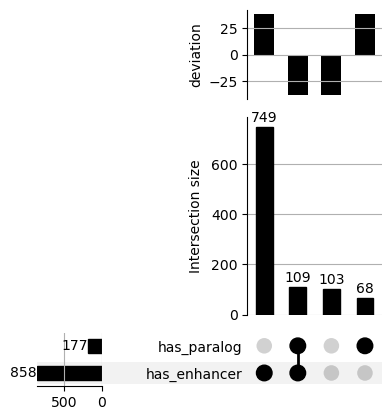

In [9]:
cluster_df['has_enhancer'] = cluster_df['num_enhancers'] > 0
plot_upset_binary_categories(cluster_df, ['has_enhancer', 'has_paralog'])

## plotting functions

#### look at distributions of varis in cluster vs null df 

In [10]:
# corrleation as a funtion of distance (split by orrientation?)

# def annotate_strands(cluster_df, gid_gencode):
#     for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
#         transcript_ids = row['Transcripts'].split(',')
#         cluster_gencode = gid_gencode.loc[transcript_ids]
#         cluster_df.loc[idx, 'strand_1'] = cluster_gencode.iloc[0].strand
#         cluster_df.loc[idx, 'strand_2'] = cluster_gencode.iloc[1].strand

# def get_orr(strands1, strands2):
#     # where they are different, conv or div based on the downstream gene identity
#     orrs = np.where(strands1 == '+', np.where(strands2 == '-', 'convergent', 'upstream_tandem'), np.where(strands2 == '-', 'downstream_tandem', 'divergent'))
#     return orrs

# def annotate_orr(cluster_df, gid_gencode):
#     annotate_strands(cluster_df, gid_gencode)
#     cluster_df['orr'] = get_orr(cluster_df['strand_1'].astype(str), cluster_df['strand_2'].astype(str))
#     cluster_df['cluster_tss_distance'] = np.where(cluster_df['strand_1'] == '-', -cluster_df['cluster_tss_size'], cluster_df['cluster_tss_size'])

# gid_gencode, full_gencode = load_gencode()
# annotate_orr(multitissue_pairs_joined_df,gid_gencode)

# sns.histplot(multitissue_pairs_joined_df, x='cluster_tss_distance', bins=np.arange(-10000, 10000, 100), hue='orr')
# plt.show()

# lim = 3000
# orr_pal = {'upstream_tandem': sns.color_palette("Paired")[0], 
#             'downstream_tandem': sns.color_palette("Paired")[1], 
#             'convergent': sns.color_palette("Paired")[2], 
#             'divergent': sns.color_palette("Paired")[3]}
# g = sns.lmplot(data=multitissue_pairs_joined_df[multitissue_pairs_joined_df['cluster_tss_size'] < lim], y='Mean_cor', x='cluster_tss_distance', 
#                x_bins=np.arange(-lim, lim, lim/50), hue='orr', height=8, aspect=2, lowess=True, palette=orr_pal)
# g.set(xlim=(-lim, lim))
# plt.show()

<AxesSubplot: xlabel='num_tads_gene', ylabel='Density'>

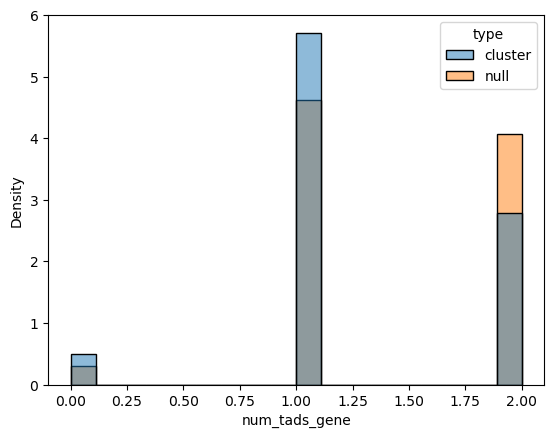

In [11]:
sns.histplot(data=joined_df, hue='type', x='num_tads_gene', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_shared_go_any', ylabel='Density'>

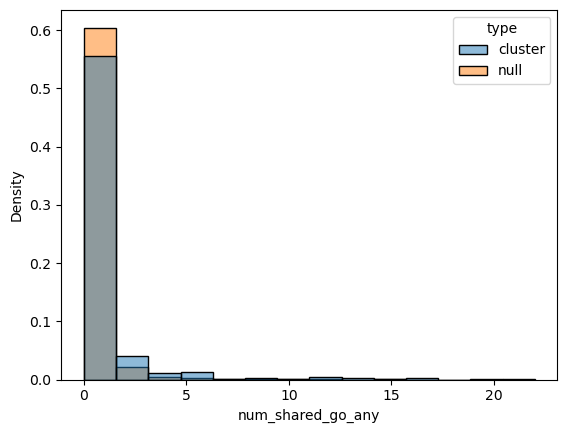

In [12]:
sns.histplot(data=joined_df, hue='type', x='num_shared_go_any', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_ctcf_peak', ylabel='Density'>

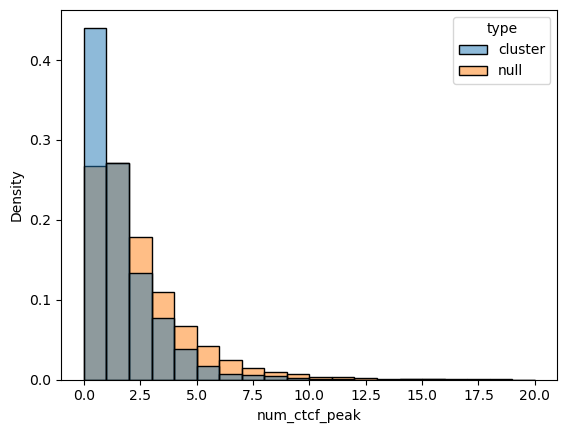

In [13]:
sns.histplot(data=joined_df, hue='type', x='num_ctcf_peak', stat='density', common_norm=False, bins=range(0, int(joined_df['num_ctcf_peak'].max())))

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Density'>

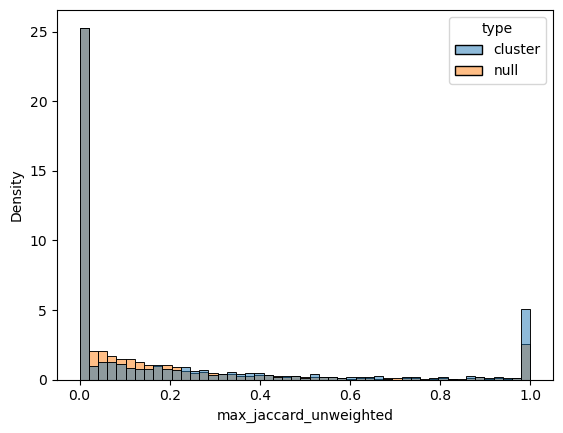

In [14]:
sns.histplot(data=joined_df, hue='type', x='max_jaccard_unweighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_abc_genes', ylabel='Density'>

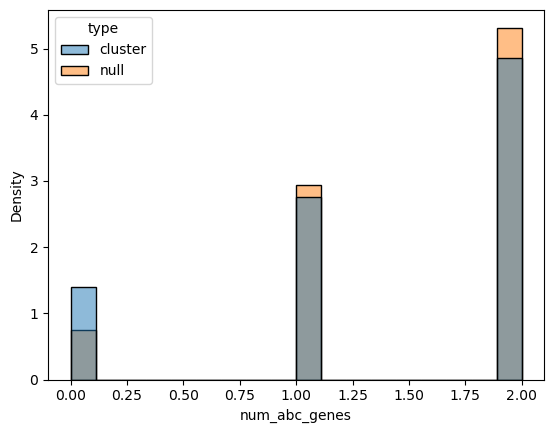

In [15]:
sns.histplot(data=joined_df, hue='type', x='num_abc_genes', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Density'>

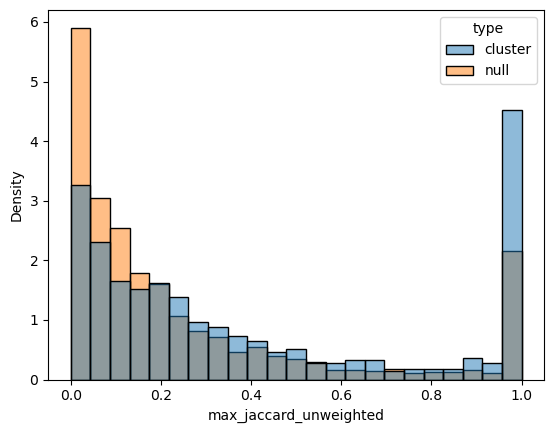

In [16]:
sns.histplot(data=joined_df[joined_df['num_abc_genes']>1], hue='type', x='max_jaccard_unweighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Density'>

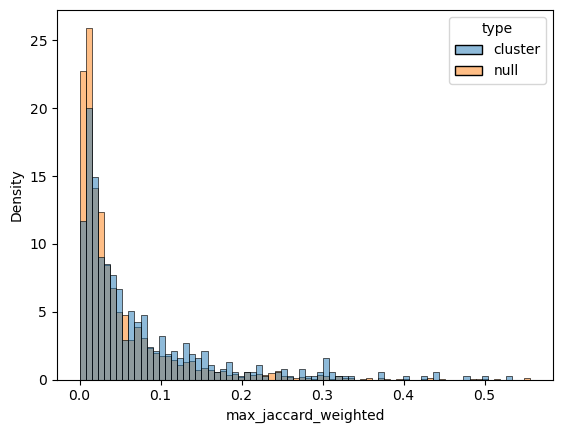

In [17]:
sns.histplot(data=joined_df[joined_df['num_abc_genes']>1], hue='type', x='max_jaccard_weighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_strong_enhancers', ylabel='Density'>

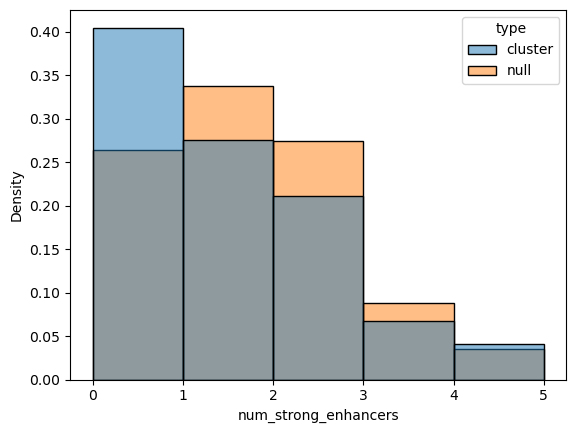

In [18]:
sns.histplot(data=joined_df, hue='type', x='num_strong_enhancers', stat='density', common_norm=False,  bins=range(0, int(joined_df['num_strong_enhancers'].max())))

In [19]:
# # I wonder if strong enhancers are more likely to regulate only 1 gene
# gene_enhancer_df = load_abc(my_tissue_id)
# enhancer_strength_df = gene_enhancer_df.reset_index().groupby('enhancer').agg({'ABC.Score':max, 'transcript_id':'nunique'})

# enhancer_strength_df['only_one_gene'] = enhancer_strength_df['transcript_id'] < 2
# enhancer_strength_df['strong'] = enhancer_strength_df['ABC.Score'] > .1

# ax = sns.violinplot(enhancer_strength_df, hue='only_one_gene', y='ABC.Score', split=True)
# ax.axhline(.1, color='k', label='strong enhancer cutoff')
# plt.show()

# sns.barplot(enhancer_strength_df, x='strong', y='only_one_gene')
# plt.show()

<AxesSubplot: xlabel='num_enhancers', ylabel='Density'>

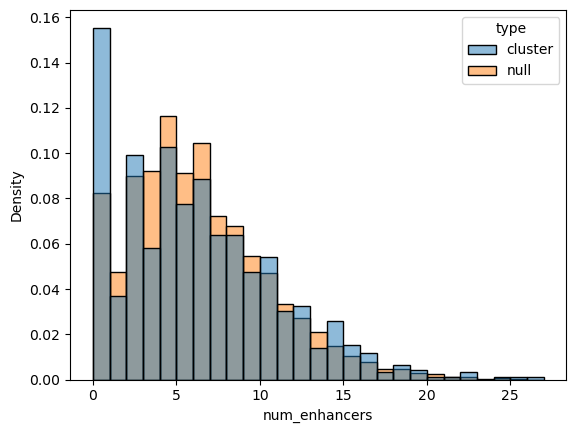

In [20]:
sns.histplot(data=joined_df, hue='type', x='num_enhancers', stat='density', common_norm=False, bins=range(0, int(joined_df['num_enhancers'].max())))

<AxesSubplot: xlabel='num_shared_enhancers', ylabel='Density'>

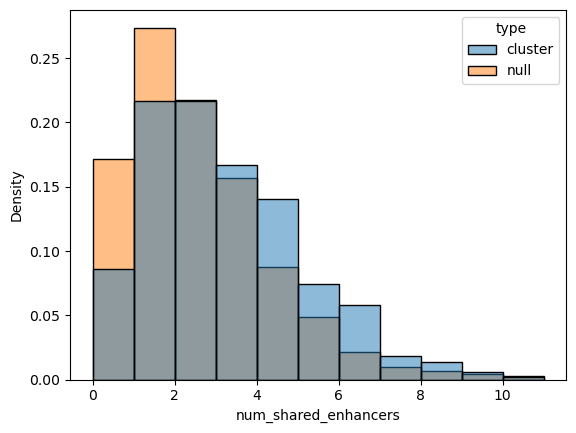

In [21]:
sns.histplot(data=joined_df[joined_df['num_abc_genes']>1], hue='type', x='num_shared_enhancers', stat='density', common_norm=False, bins=range(0, int(joined_df['num_shared_enhancers'].max())))

<AxesSubplot: xlabel='cluster_size', ylabel='Density'>

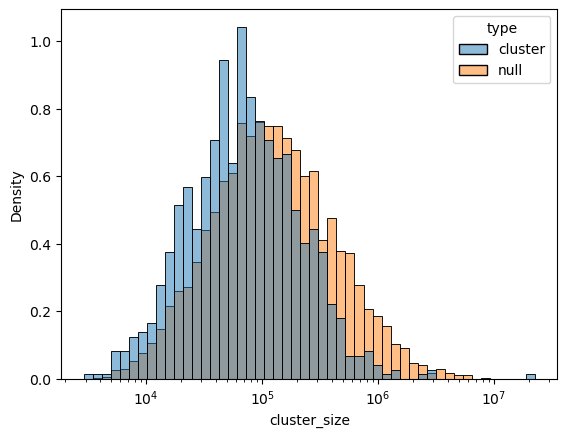

In [22]:
sns.histplot(data=joined_df, hue='type', x='cluster_size', stat='density', log_scale=True, common_norm=False)

<AxesSubplot: xlabel='cluster_tss_size', ylabel='Density'>

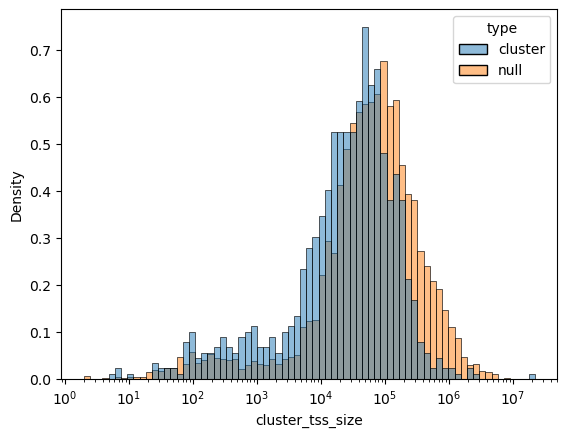

In [23]:
sns.histplot(data=joined_df, hue='type', x='cluster_tss_size', stat='density', log_scale=True, common_norm=False)

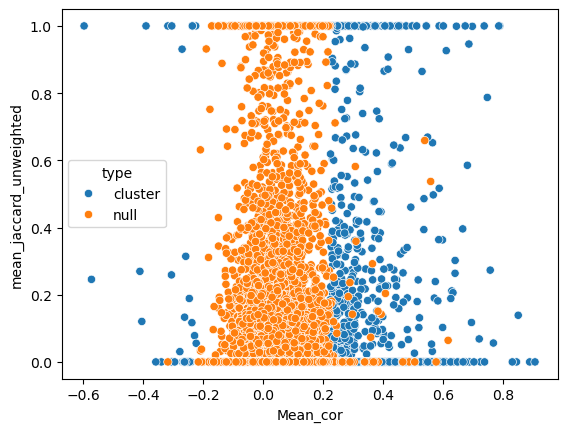

PearsonRResult(statistic=0.07006797087430869, pvalue=8.799354325603602e-08)

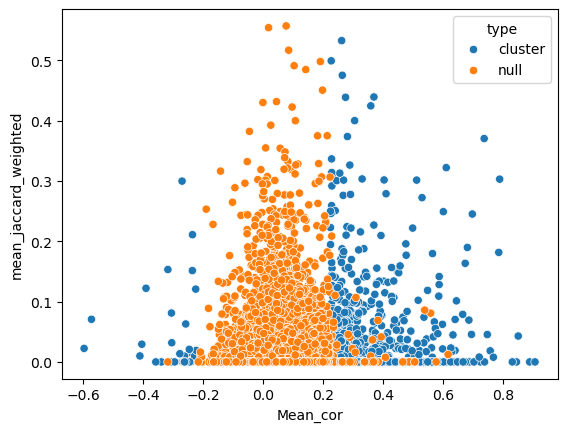

In [24]:
sns.scatterplot(joined_df[~joined_df['mean_jaccard_unweighted'].isna()], x='Mean_cor', y='mean_jaccard_unweighted', hue='type')
plt.show()
sns.scatterplot(joined_df[~joined_df['mean_jaccard_weighted'].isna()], x='Mean_cor', y='mean_jaccard_weighted', hue='type')

stats.pearsonr(joined_df[~joined_df['mean_jaccard_unweighted'].isna()]['mean_jaccard_unweighted'], joined_df[~joined_df['mean_jaccard_unweighted'].isna()]['Mean_cor'])

### log odds

In [25]:
# plot odds ratios

def get_odds_ratio(contingency_table, verb=0):
    # One-sided Fisher's exact test
    odds_ratio, p_value = stats.fisher_exact(contingency_table)
    if verb > 0:
        print("Odds Ratio:", odds_ratio)
        print("P-value:", p_value)

    # Compute 95% confidence interval for odds ratio
    a, b, c, d = contingency_table.flatten()
    SE = np.sqrt(1/a + 1/b + 1/c + 1/d)
    if odds_ratio==0:
        lcb=0
        ucb=0
    else:
        lcb = math.exp(math.log(odds_ratio) - 1.96*SE)  # lower confidence bound
        ucb = math.exp(math.log(odds_ratio) + 1.96*SE)  # upper confidence bound
    if verb > 0:
        print(f"CI: [{lcb}, {ucb}]")

    return p_value, odds_ratio, lcb, ucb

def get_contingency_table(cluster_df, null_df, column_name):
    num_cluster = sum(cluster_df[column_name])
    num_null = sum(null_df[column_name])
    # Build contingency table
    # [[yes clusters, no clusters] [yes null, no null]]
    contingency_table = np.array([[num_cluster, len(cluster_df)-num_cluster],[num_null, len(null_df)-num_null]])
    return contingency_table

def get_log_odds(cluster_df, null_df, column_list):
    log_odds_df = []
    for column_name in column_list:
        p_value, odds_ratio, lcb, ucb = get_odds_ratio(get_contingency_table(cluster_df, null_df, column_name))
        log_odds_df.append(pd.Series({'p_value': p_value,
                'odds_ratio':odds_ratio,
                'lower_cb':lcb,
                'upper_cb':ucb,
                'lower_cb_diff': odds_ratio - lcb,
                'upper_cb_diff': ucb - odds_ratio,
                'col':column_name}))
    return pd.DataFrame(log_odds_df)


# percent belonging to category
def get_frac(column_name, df):
    return sum(df[column_name])/len(df)

In [26]:
def plot_log_odds(cluster_df, null_df, column_list):
    log_odds_df = get_log_odds(cluster_df,null_df, column_list)
    log_odds_df['frac_cluster'] = log_odds_df['col'].apply(get_frac, args=(cluster_df,))
    log_odds_df['frac_null'] = log_odds_df['col'].apply(get_frac, args=(null_df,))
    return make_log_odds_frac_plot(log_odds_df)

def make_log_odds_frac_plot(log_odds_df):
    fig, axes = plt.subplots(1, 2, figsize=(12,9))
    make_log_odds_plot(log_odds_df, ax=axes[0])
    make_fraction_plot(log_odds_df, ax=axes[1])
    axes[0].set_ylim(axes[1].get_ylim())
    return axes


def make_log_odds_plot(log_odds_df, ax=None):
    log_odds_df = log_odds_df.reset_index()
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))

    # log odds plot
    ax.errorbar(y=log_odds_df['col'], x=log_odds_df['odds_ratio'], xerr=log_odds_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", color='k')
    ax.axvline(1, color='k', linestyle='--')
    ax.set_xlabel('Log odds')

    for idx,row in log_odds_df.iterrows():
        ax.annotate('OR: {:.2f},\np: {:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2))
        #axes[0].annotate('log odds={:.1f}'.format(np.log(row['odds_ratio'])), (row['odds_ratio'], idx-.3))
    ax.set_xscale(u'log')
    return ax


def make_fraction_plot(log_odds_df, ax=None):
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))
    # fraction plot
    sns.barplot(data=log_odds_df, x='frac_cluster', y='col', ax=ax)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('Fraction in category')

    # make the labels match in order and position
    ax.invert_yaxis()
    return ax

/local/scratch/klawren/slrmtmp.46562935/ipykernel_39064/3080165456.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  SE = np.sqrt(1/a + 1/b + 1/c + 1/d)


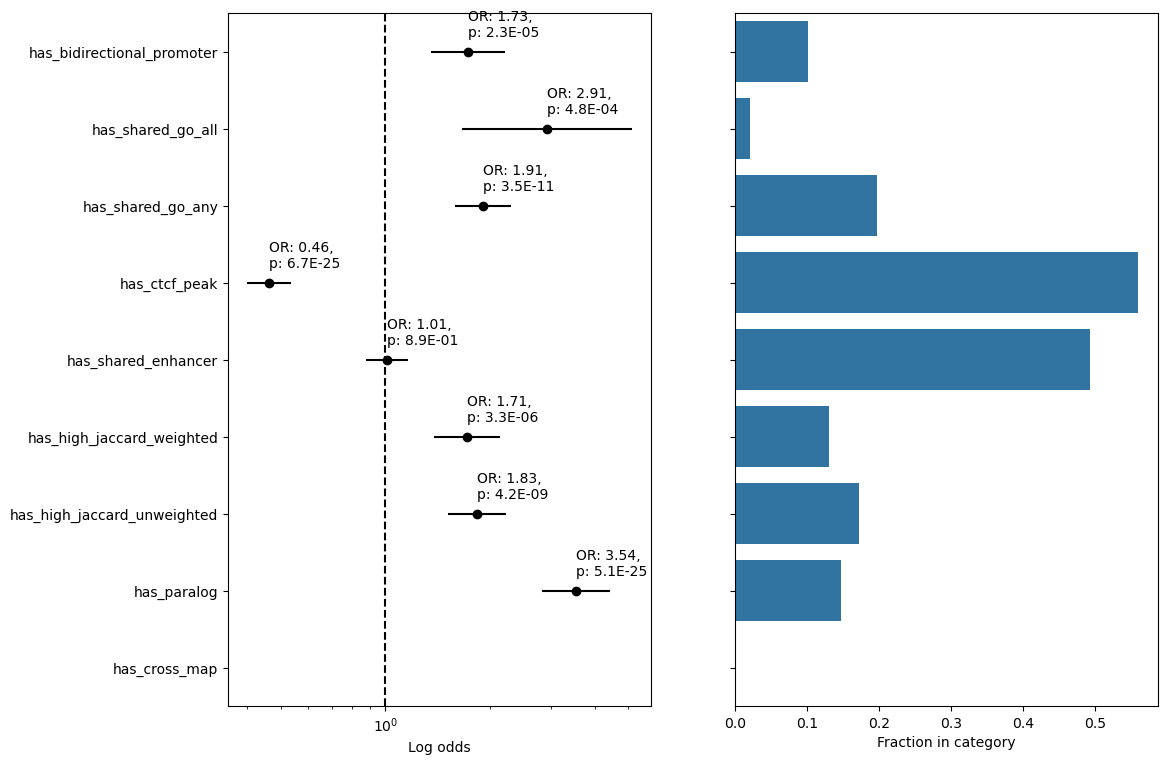

In [27]:
axes = plot_log_odds(cluster_df[(cluster_df['N_genes']==2)&(cluster_df['has_cross_map']==False)], null_pairs_exclude_clusters[null_pairs_exclude_clusters['has_cross_map']==False], ['has_cross_map',
                                                                        'has_paralog', 
                                                                        'has_high_jaccard_unweighted', 
                                                                        'has_high_jaccard_weighted', 
                                                                        'has_shared_enhancer', 
                                                                        'has_ctcf_peak',
                                                                        #'has_complexes', 
                                                                        'has_shared_go_any', 
                                                                        'has_shared_go_all', 
                                                                        'has_bidirectional_promoter'])
#axes[0].set_title('Excluding cross mappable genes')

Text(0.5, 1.0, 'only pairs that both are in the abc dataset')

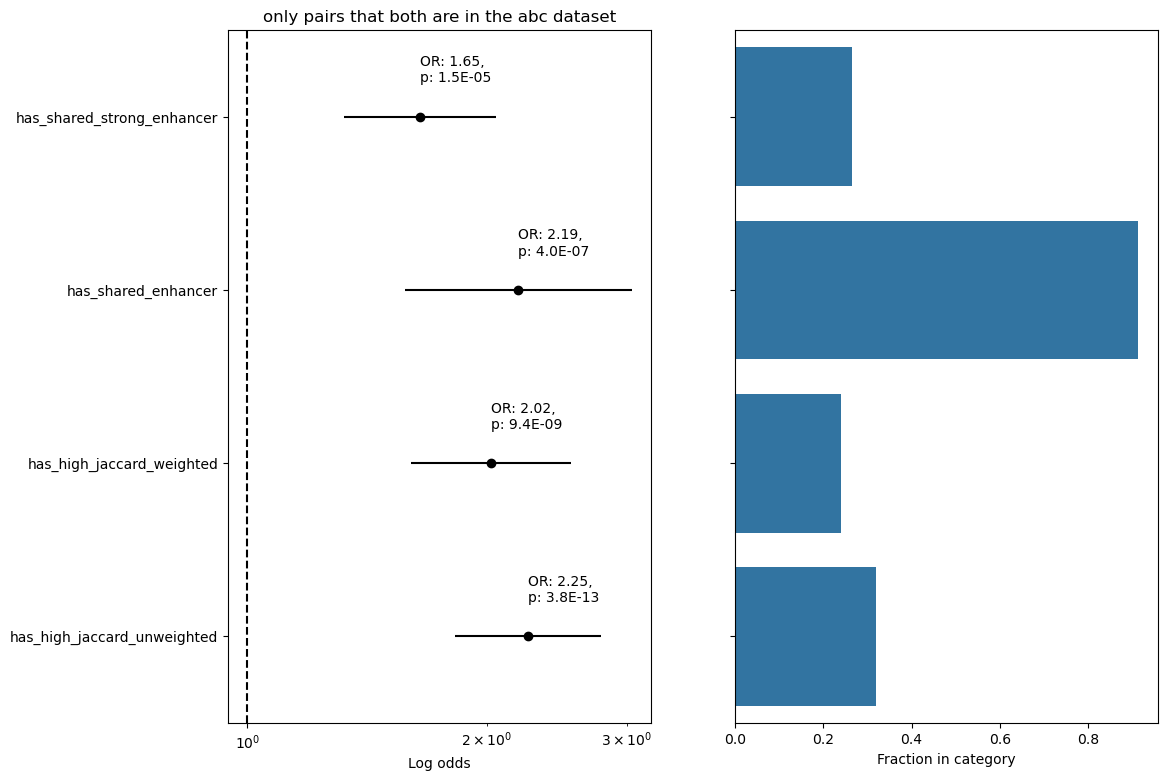

In [28]:
axes = plot_log_odds(cluster_df[(cluster_df['N_genes']==2)&(cluster_df['num_abc_genes']>1)], null_pairs_exclude_clusters[(null_pairs_exclude_clusters['num_abc_genes']>1)], [
                                                                        'has_high_jaccard_unweighted', 
                                                                        'has_high_jaccard_weighted', 
                                                                        'has_shared_enhancer', 
                                                                        'has_shared_strong_enhancer'])

axes[0].set_title('only pairs that both are in the abc dataset')

## logistic regression model for continuous vars

using the number of things for the continuous variables
* num_ctcf_peak
* mean_jaccard_weighted
* log cluster_tss_size
* num_shared_go_any


binary vars (for pairs)
* num_cross_map
* num_paralog
* num_bidirectional_promoter
* num_shared_go_all

this approach also allows us to include N_genes as a covariate

In [29]:
import statsmodels.api as sm

In [30]:
# add log size (for size corrections)
cluster_df['log_size'] = np.log10(cluster_df['cluster_tss_size'])
null_pairs_exclude_clusters['log_size'] = np.log10(null_pairs_exclude_clusters['cluster_tss_size'])

cluster_df['has_multiple_abc_genes'] = cluster_df['num_abc_genes'] > 1
null_pairs_exclude_clusters['has_multiple_abc_genes'] = null_pairs_exclude_clusters['num_abc_genes'] > 1

joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])

In [31]:
# fit a logit model

def fit_logistic_model(joined_df, column, correct_on=False, filter_on_column=None, verb=True, correct_on_column='log_size'):
    if verb:
        print(column)
    try:
        final_joined_df = joined_df[joined_df[filter_on_column]]
    except KeyError:
        final_joined_df = joined_df

    if correct_on:
        x = final_joined_df[np.append(np.asarray(correct_on_column),column)].astype(float)
    else:
        x = final_joined_df[column].astype(float)

    y = final_joined_df.reset_index()['type'].values == 'cluster'
    x_with_constant = sm.add_constant(x) # Add intercept term

    logit_model = sm.Logit(y, x_with_constant)
    try:
        result = logit_model.fit()
        
    except np.linalg.LinAlgError:
        # this can happen if all elements are the same
        return pd.Series({'lower_cb':np.nan, 'upper_cb':np.nan, 'odds_ratio':np.nan, 'p_value':np.nan, 'col':column,'lower_cb_diff':np.nan , 'upper_cb_diff':np.nan}, name=column)
        print(joined_df.head())
        print(column)
        sns.histplot(joined_df[column])
        raise np.linalg.LinAlgError
    if verb:
        print(result.summary())

    coefficients = result.params
    conf_int = result.conf_int()
    odds_ratios = np.exp(coefficients)
    odds_ratios_ci = np.exp(conf_int)

    odds_ratios_ci.rename(columns={0:'lower_cb', 1:'upper_cb'}, inplace=True)
    odds_ratios_ci['odds_ratio'] = odds_ratios
    odds_ratios_ci['p_value'] = result.pvalues
    odds_ratios_ci['col'] = column
    odds_ratios_ci['lower_cb_diff'] = odds_ratios_ci['odds_ratio'] - odds_ratios_ci['lower_cb']
    odds_ratios_ci['upper_cb_diff'] = odds_ratios_ci['upper_cb'] - odds_ratios_ci['odds_ratio']
    
    return odds_ratios_ci.loc[column]


def get_odds_df(joined_df, verb=True, correct_on=False, correct_on_column='log_size', column_list = ['num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any','has_shared_enhancer',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size', 'max_jaccard_unweighted', 'max_jaccard_weighted', 'has_tads_tss'], 
       filter_list=['max_jaccard_unweighted', 'max_jaccard_weighted', 'num_shared_strong_enhancers', 'num_shared_enhancers', 'has_shared_enhancer'], 
       filter_on_column = 'has_multiple_abc_genes'):
       column_list = pd.Series(column_list)
       odds_ratios_no_filter = pd.DataFrame([fit_logistic_model(joined_df, c, verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[~column_list.isin(filter_list)]]) 
       odds_ratios_filtered = pd.DataFrame([fit_logistic_model(joined_df, c, filter_on_column=filter_on_column, verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[column_list.isin(filter_list)]]) 
       return pd.concat([odds_ratios_no_filter, odds_ratios_filtered])

In [32]:
# log odds plot with multiple odds per category 
def make_log_odds_plot_multiple(odds_ratios_list, ax=None, labels=None, add_annotations=True, offset = 0.2, colors = sns.color_palette()):
    
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))
    
    for idx, odds_ratio_df in enumerate(odds_ratios_list):
        odds_ratio_df = odds_ratio_df.reindex(odds_ratios_list[0].index).reset_index()
        color = colors[idx % len(colors)]  # cycle through colors if more than available
        ax.errorbar(y=odds_ratio_df.reset_index().index.values + idx*offset, x=odds_ratio_df['odds_ratio'], 
                    xerr=odds_ratio_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", 
                    color=color, label=labels[idx] if labels else None, markersize=3)
        ax.axvline(1, color='k', linestyle='--')

        if add_annotations:
            for row_idx, row in odds_ratio_df.iterrows():
                ax.annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), 
                            (row['odds_ratio'], row_idx + idx*offset + 0.05), fontsize=6)
            
    if labels:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))

    ax.set_xscale(u'log')
    ax.set_yticks(ticks=odds_ratio_df.index.values + (len(odds_ratios_list)-1)*offset/2, labels=(odds_ratio_df['col']))
    return ax

### basic model, odds for each param

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.436735
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5818
Model:                          Logit   Df Residuals:                     5816
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                0.003516
Time:                        17:44:04   Log-Likelihood:                -2540.9
converged:                       True   LL-Null:                       -2549.9
Covariance Type:            nonrobust   LLR p-value:                 2.288e-05
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.7082      0.038 

<AxesSubplot: xlabel='Log odds'>

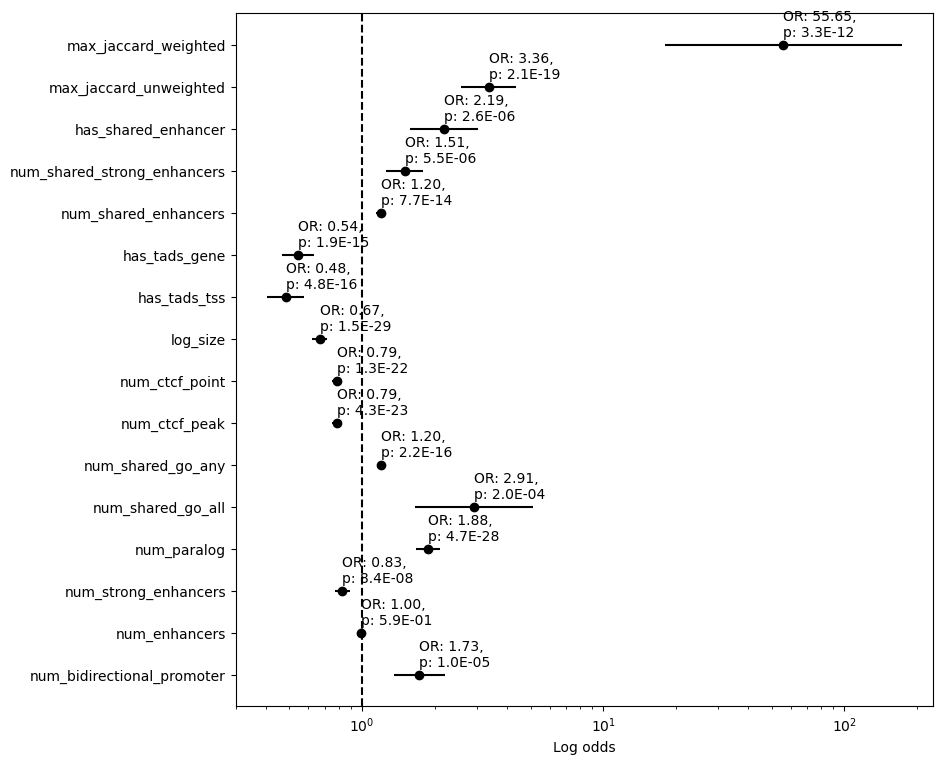

In [33]:
odds_ratios = get_odds_df(joined_df, column_list = ['num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any', 'has_shared_enhancer',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size', 'max_jaccard_unweighted', 'max_jaccard_weighted', 'has_tads_tss', 'has_tads_gene'])
make_log_odds_plot(odds_ratios.reset_index())

### positive vs negative correlation

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.098719
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4993
Model:                          Logit   Df Residuals:                     4991
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                0.002098
Time:                        17:44:05   Log-Likelihood:                -492.90
converged:                       True   LL-Null:                       -493.94
Covariance Type:            nonrobust   LLR p-value:                    0.1499
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -3.9212      0.106 

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4993
Model:                          Logit   Df Residuals:                     4991
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                 0.06654
Time:                        17:44:06   Log-Likelihood:                -461.07
converged:                       True   LL-Null:                       -493.94
Covariance Type:            nonrobust   LLR p-value:                 5.160e-16
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.0959      0.111    -36.917      0.000      -4.313      -3.878
num_shared_go_any     0.2932      0.032      9.096      0.000       0.230       0.356
num_ctcf_peak
Optimizati

(0.01, 100)

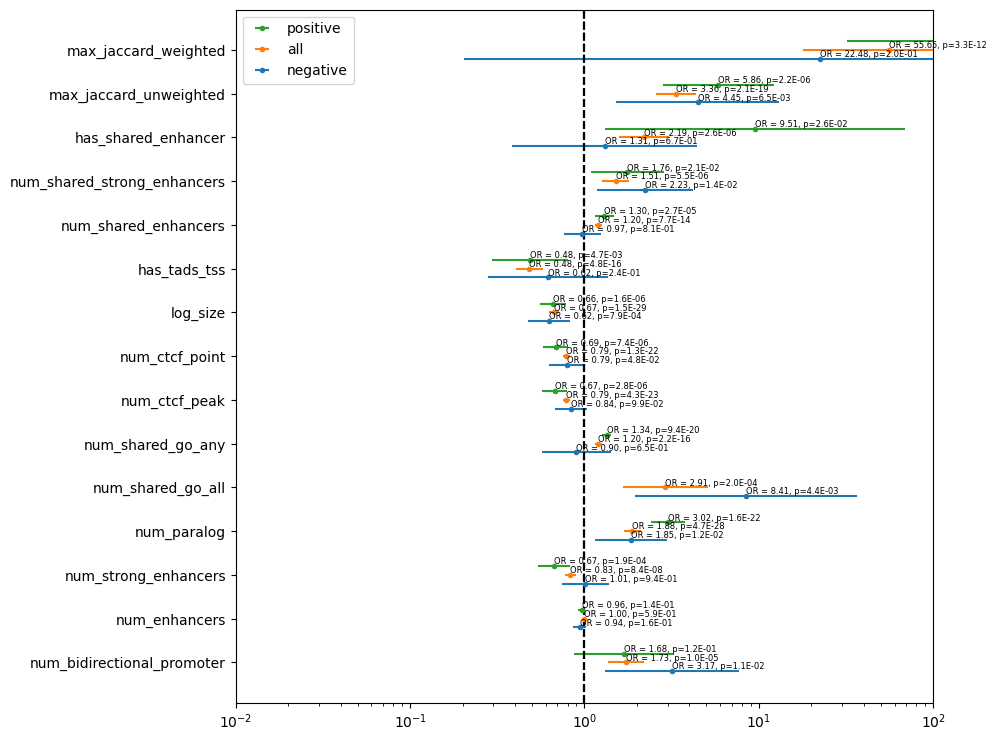

In [34]:
pos_cluster_df = pd.concat([cluster_df[(cluster_df['N_genes']==2) & (cluster_df['has_high_pos_corr'])], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])
pos_cluster_df = pos_cluster_df[~pos_cluster_df['has_cross_map']]
odds_ratios_positive = get_odds_df(pos_cluster_df)

neg_cluster_df = pd.concat([cluster_df[(cluster_df['N_genes']==2) & (cluster_df['has_neg_corr'])], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])
neg_cluster_df = neg_cluster_df[~neg_cluster_df['has_cross_map']]
odds_ratios_negative = get_odds_df(neg_cluster_df)

ax = make_log_odds_plot_multiple([odds_ratios_negative,  get_odds_df(joined_df), odds_ratios_positive], labels=['negative', 'all', 'positive'])
ax.set_xlim([.01, 100])

## combining over all tissues

# only combine over tissues with a gtex match
GTEX_tissue,ABC_biosample_id
Adipose_Subcutaneous,adipose_tissue-ENCODE
Adipose_Visceral_Omentum,None
Artery_Tibial,coronary_artery-ENCODE
Cells_Cultured_fibroblasts,fibroblast_of_arm-ENCODE
Esophagus_Mucosa,None
Esophagus_Muscularis,None
Lung,fibroblast_of_lung-Roadmap
Muscle_Skeletal,gastrocnemius_medialis-ENCODE
Nerve_Tibial,None
Skin_Not_Sun_Exposed_Suprapubic,foreskin_fibroblast-Roadmap
Skin_Sun_Exposed_Lower_leg,fibroblast_of_dermis-Roadmap
Thyroid,thyroid_gland-ENCODE
Whole_Blood,Bcells

Adipose_Subcutaneous, Artery_Tibial, Cells_Cultured_fibroblasts, Lung, Muscle_Skeletal, Skin_Not_Sun_Exposed_Suprapubic, Skin_Sun_Exposed_Lower_leg, Thyroid, Whole_Blood

In [35]:
enhancer_tissue_ids = ['Artery_Tibial', 'Cells_Cultured_fibroblasts', 'Lung', 'Muscle_Skeletal', 'Skin_Not_Sun_Exposed_Suprapubic', 'Skin_Sun_Exposed_Lower_leg', 'Thyroid']
multitissue_pairs_abc_joined_df = multitissue_pairs_joined_df[multitissue_pairs_joined_df['tissue'].isin(enhancer_tissue_ids)]

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.406925
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5706
Model:                          Logit   Df Residuals:                     5704
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                0.003850
Time:                        17:44:09   Log-Likelihood:                -2321.9
converged:                       True   LL-Null:                       -2330.9
Covariance Type:            nonrobust   LLR p-value:                 2.272e-05
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8456      0.040 

(0.01, 100)

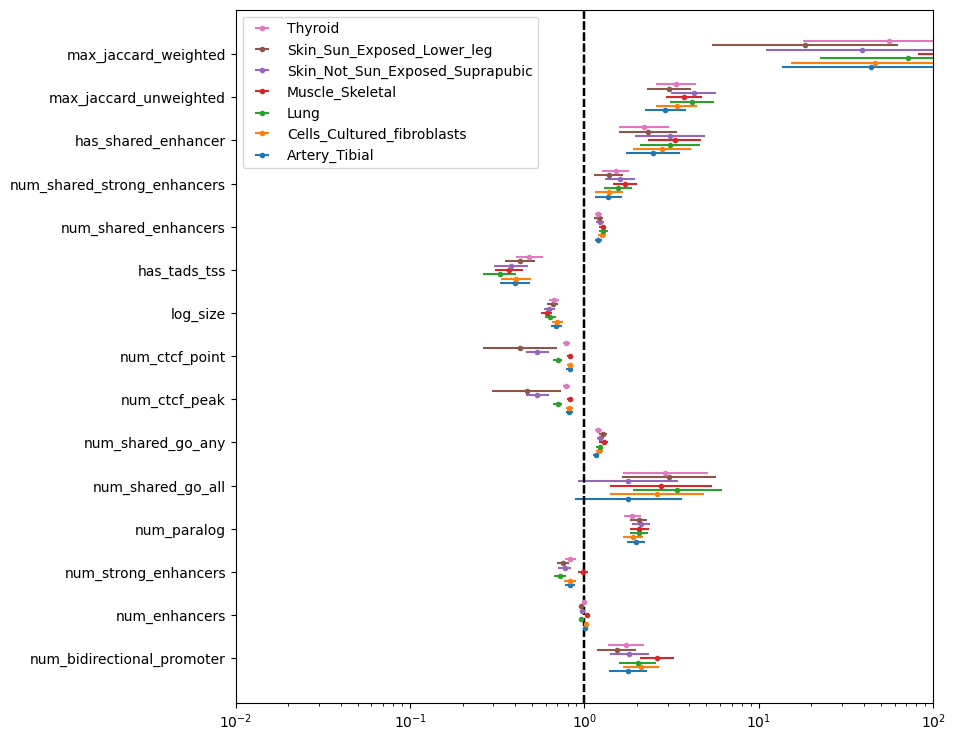

In [36]:
# individual per tissue
odds_ratios = [get_odds_df(multitissue_pairs_abc_joined_df[multitissue_pairs_abc_joined_df['tissue']==t]) for t in enhancer_tissue_ids]
ax = make_log_odds_plot_multiple(odds_ratios, labels=enhancer_tissue_ids, add_annotations=False, offset=.1)
ax.set_xlim(.01, 100)

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.401857
         Iterations 6


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                39765
Model:                          Logit   Df Residuals:                    39763
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                0.005414
Time:                        17:44:16   Log-Likelihood:                -15980.
converged:                       True   LL-Null:                       -16067.
Covariance Type:            nonrobust   LLR p-value:                 1.007e-39
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8774      0.015   -122.362      0.000      -1.907      -1.847
num_bidirectional_promoter     0.6552      0.047     13.875      0.000       0.563 

<AxesSubplot: >

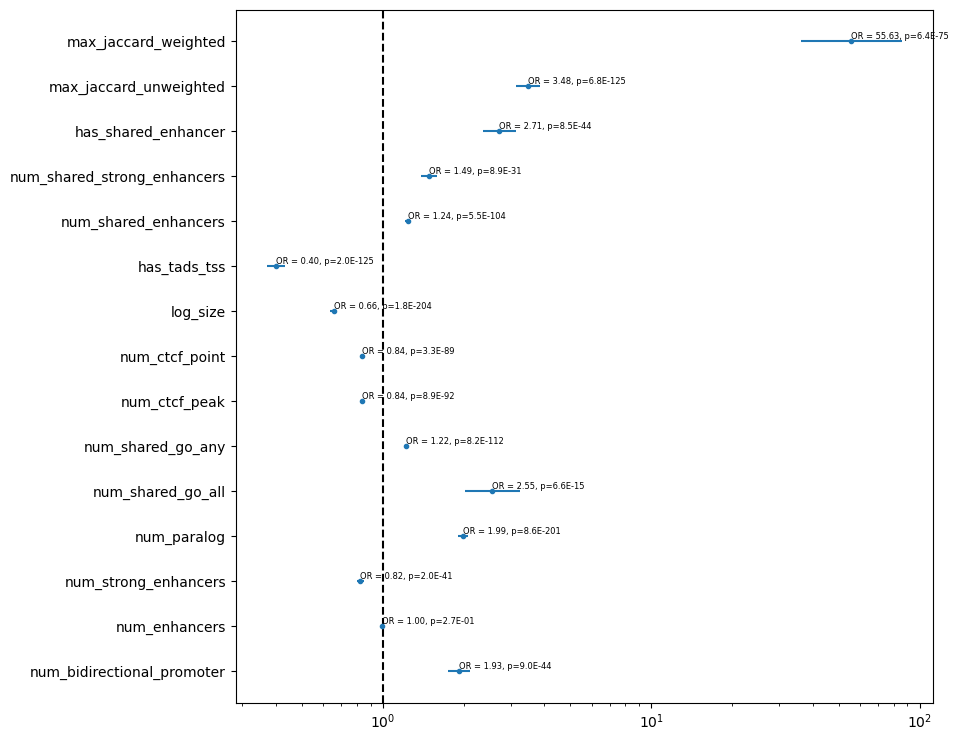

In [37]:
# these look reasonably similar, combine over them
odds_ratios_enhancer = get_odds_df(multitissue_pairs_abc_joined_df)
make_log_odds_plot_multiple([odds_ratios_enhancer])

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.078858
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                34750
Model:                          Logit   Df Residuals:                    34748
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                0.003983
Time:                        17:44:21   Log-Likelihood:                -2740.3
converged:                       True   LL-Null:                       -2751.3
Covariance Type:            nonrobust   LLR p-value:                 2.847e-06
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.2255      0.047 

<AxesSubplot: >

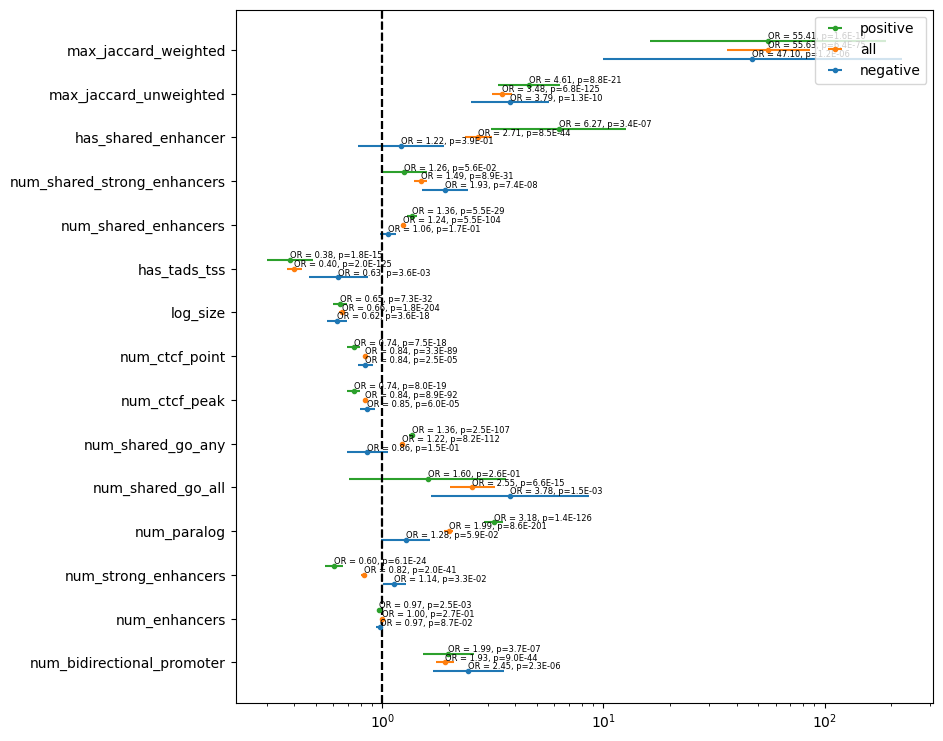

In [38]:
# positive negative plot combining over tissues
multitissue_pairs_abc_joined_df  = multitissue_pairs_abc_joined_df.reset_index()
combined_pos_df = multitissue_pairs_abc_joined_df[((multitissue_pairs_abc_joined_df['type']=='cluster')&(multitissue_pairs_abc_joined_df['has_high_pos_corr'])) | (multitissue_pairs_abc_joined_df['type']=='null')]
combined_neg_df = multitissue_pairs_abc_joined_df[((multitissue_pairs_abc_joined_df['type']=='cluster')&(multitissue_pairs_abc_joined_df['has_neg_corr'])) | (multitissue_pairs_abc_joined_df['type']=='null')]
odds_ratios_positive = get_odds_df(combined_pos_df)
odds_ratios_negative = get_odds_df(combined_neg_df)

make_log_odds_plot_multiple([odds_ratios_negative, odds_ratios_enhancer, odds_ratios_positive], labels=['negative', 'all', 'positive'])


### distance correction
* with log_size as a covariate
* with resampled size

I think resampled size is better, since the size distribution is not normal

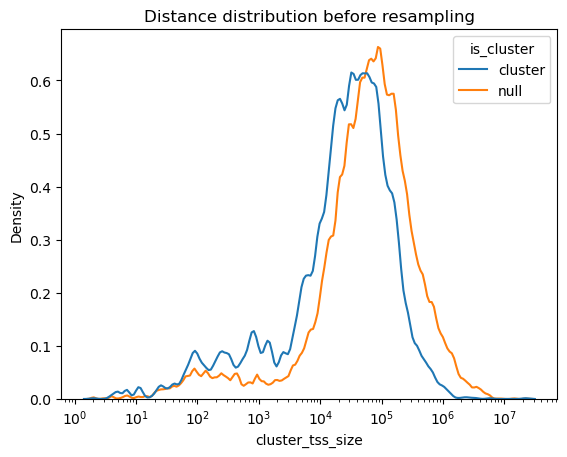

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())


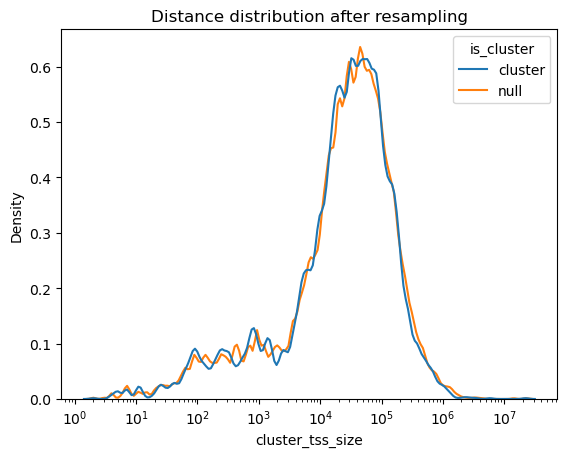

In [39]:
multitissue_pairs_abc_resamp_null = get_resamp_null_cluster(combined_multigene_nulls[(combined_multigene_nulls['N_genes']==2) & (combined_multigene_nulls['tissue'].isin(enhancer_tissue_ids))], 
                                                          combined_clusters[(combined_clusters['N_genes']==2) & (combined_clusters['tissue'].isin(enhancer_tissue_ids))], number_null=5000*len(enhancer_tissue_ids), plot=True)

multitissue_pairs_abc_resamp_df = pd.concat([combined_clusters[(combined_clusters['N_genes']==2) & (combined_clusters['tissue'].isin(enhancer_tissue_ids))], multitissue_pairs_abc_resamp_null], keys=['cluster', 'null'], names=['type', 'idx'])
multitissue_pairs_abc_resamp_df.reset_index(inplace=True)


num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.399118
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40547
Model:                          Logit   Df Residuals:                    40545
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:               4.830e-06
Time:                        17:44:43   Log-Likelihood:                -16183.
converged:                       True   LL-Null:                       -16183.
Covariance Type:            nonrobust   LLR p-value:                    0.6926
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8442      0.015 

<AxesSubplot: >

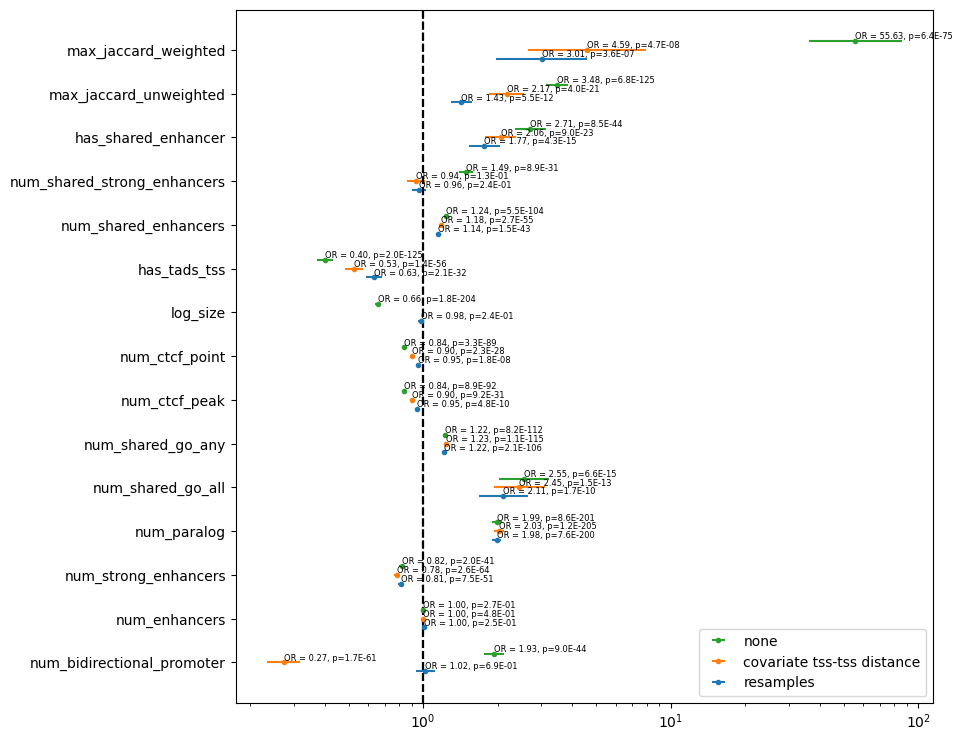

In [40]:
make_log_odds_plot_multiple([get_odds_df(multitissue_pairs_abc_resamp_df), get_odds_df(multitissue_pairs_abc_joined_df, correct_on=True), get_odds_df(multitissue_pairs_abc_joined_df)], labels=['resamples', 'covariate tss-tss distance', 'none'])

### boolean labels

useing boolean columns again so odds ratios acutally mean something
odds_ratios_enhancer

max_jaccard_weighted_100
Optimization terminated successfully.
         Current function value: 0.378281
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                23694
Model:                          Logit   Df Residuals:                    23692
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                 0.01664
Time:                        17:44:57   Log-Likelihood:                -8963.0
converged:                       True   LL-Null:                       -9114.6
Covariance Type:            nonrobust   LLR p-value:                 6.457e-68
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.1538      0.025    -87.1

<AxesSubplot: xlabel='Log odds'>

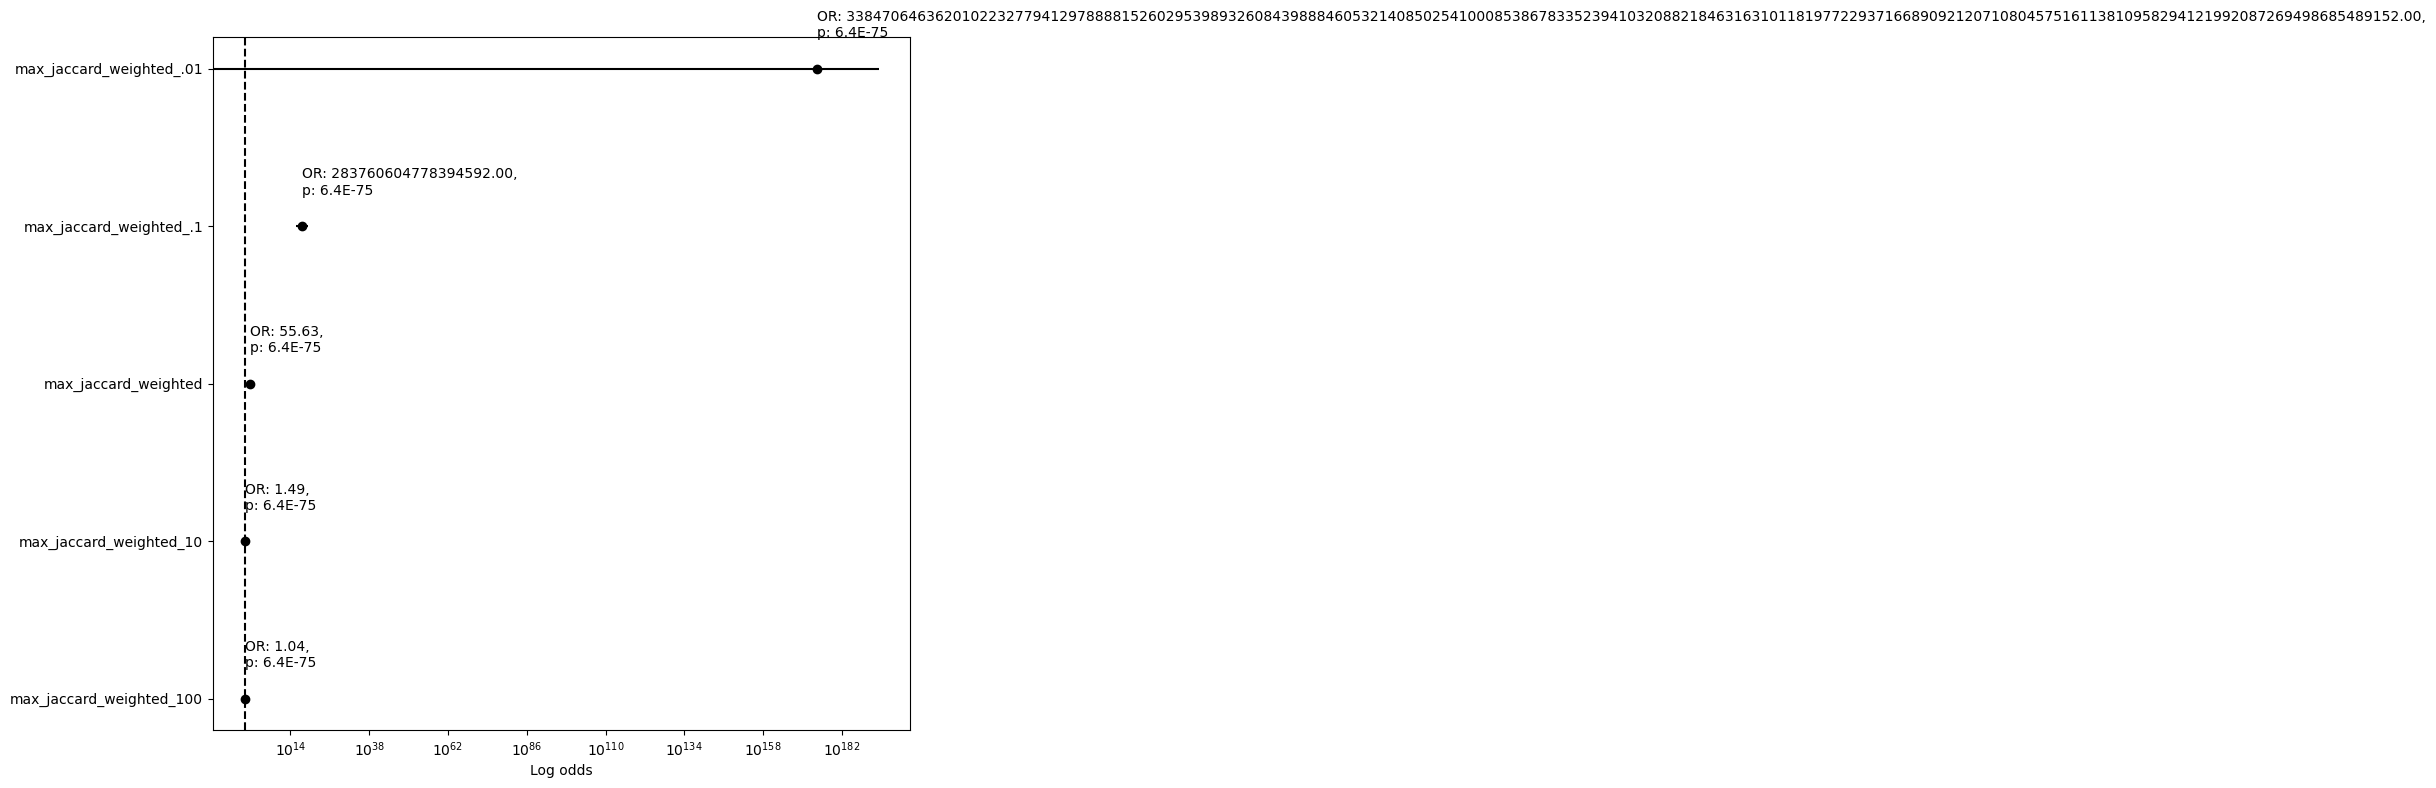

In [41]:
multitissue_pairs_abc_joined_df['max_jaccard_weighted_10'] = multitissue_pairs_abc_joined_df['max_jaccard_weighted'] * 10
multitissue_pairs_abc_joined_df['max_jaccard_weighted_100'] = multitissue_pairs_abc_joined_df['max_jaccard_weighted'] * 100

multitissue_pairs_abc_joined_df['max_jaccard_weighted_.1'] = multitissue_pairs_abc_joined_df['max_jaccard_weighted']/ 10
multitissue_pairs_abc_joined_df['max_jaccard_weighted_.01'] = multitissue_pairs_abc_joined_df['max_jaccard_weighted']/100

odds_ratios_jaccard_scaled = get_odds_df(multitissue_pairs_abc_joined_df, column_list=['max_jaccard_weighted_100','max_jaccard_weighted_10','max_jaccard_weighted', 'max_jaccard_weighted_.1', 'max_jaccard_weighted_.01'], 
filter_list=['max_jaccard_weighted_100','max_jaccard_weighted_10','max_jaccard_weighted', 'max_jaccard_weighted_.1', 'max_jaccard_weighted_.01'])

make_log_odds_plot(odds_ratios_jaccard_scaled)

In [42]:
bool_column_list = ['num_paralog', 'has_paralog', 
                    'max_jaccard_unweighted', 'has_high_jaccard_unweighted', 
                    'max_jaccard_weighted', 'has_high_jaccard_weighted', 
                    'num_shared_enhancers', 'has_shared_enhancer', 
                    'num_ctcf_peak', 'has_ctcf_peak', 
                    'num_ctcf_point', 'has_ctcf_point', 
                    'num_shared_go_any', 'has_shared_go_any', 
                    'num_shared_go_all', 'has_shared_go_all', 
                    'num_bidirectional_promoter', 'has_bidirectional_promoter']
bool_filter_list = ['max_jaccard_unweighted', 'has_high_jaccard_unweighted', 
                    'max_jaccard_weighted', 'has_high_jaccard_weighted', 
                    'num_shared_enhancers', 'has_shared_enhancer']


num_paralog
Optimization terminated successfully.
         Current function value: 0.039172
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                35229
Model:                          Logit   Df Residuals:                    35227
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                0.001083
Time:                        17:44:59   Log-Likelihood:                -1380.0
converged:                       True   LL-Null:                       -1381.5
Covariance Type:            nonrobust   LLR p-value:                   0.08362
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.0565      0.069    -73.563      0.000      -5.191      -4.922
num_paralog   

<AxesSubplot: >

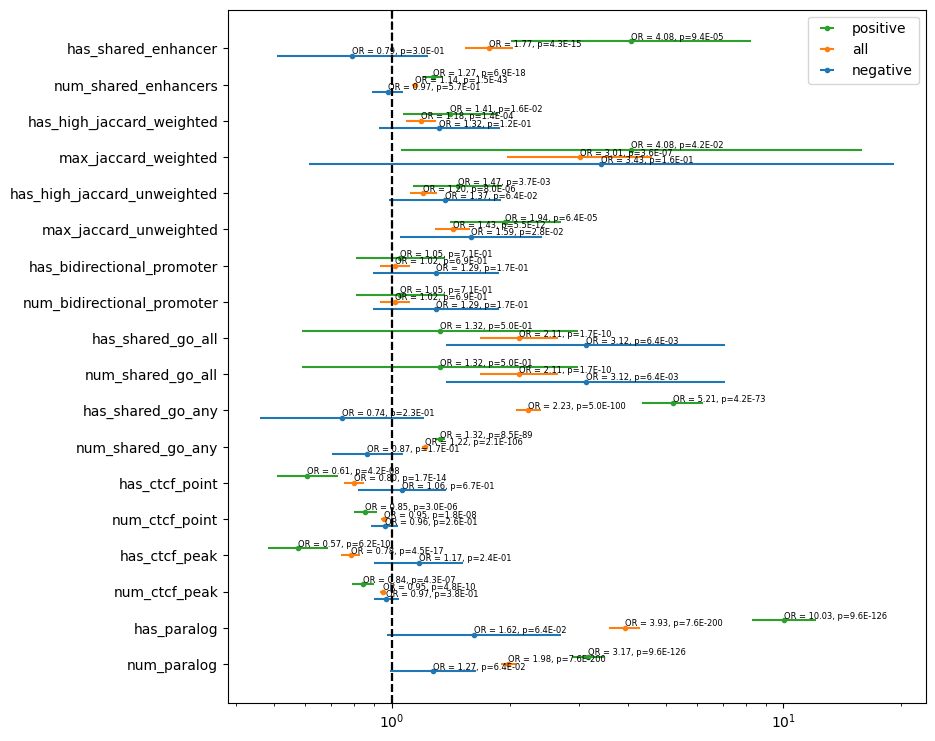

In [43]:
# combined, resamples
make_log_odds_plot_multiple([get_odds_df(multitissue_pairs_abc_resamp_df[((multitissue_pairs_abc_resamp_df['type']=='cluster')&(multitissue_pairs_abc_resamp_df['has_neg_corr'])) | (multitissue_pairs_abc_resamp_df['type']=='null')], column_list=bool_column_list, filter_list=bool_filter_list), 
                             get_odds_df(multitissue_pairs_abc_resamp_df, column_list=bool_column_list, filter_list=bool_filter_list), 
                             get_odds_df(multitissue_pairs_abc_resamp_df[((multitissue_pairs_abc_resamp_df['type']=='cluster')&(multitissue_pairs_abc_resamp_df['has_high_pos_corr'])) | (multitissue_pairs_abc_resamp_df['type']=='null')], column_list=bool_column_list, filter_list=bool_filter_list)], 
                             labels=['negative', 'all', 'positive'])

### bigger clusters
* broken down by cluster size
* with n_genes as covariate

using resampled distance matched nulls
using all tissue combined

In [44]:
multitissue_abc_largerclusters_df = pd.concat([combined_clusters[(combined_clusters['tissue'].isin(enhancer_tissue_ids))], combined_multigene_nulls[(combined_multigene_nulls['tissue'].isin(enhancer_tissue_ids))]], keys=['cluster', 'null'], names=['type', 'idx'])
multitissue_abc_largerclusters_df.reset_index(inplace=True)

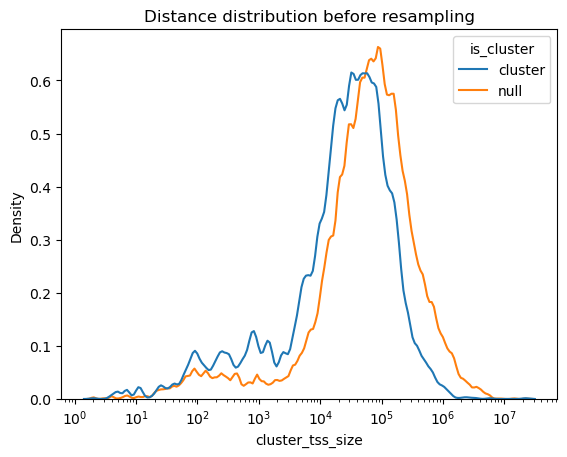

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())


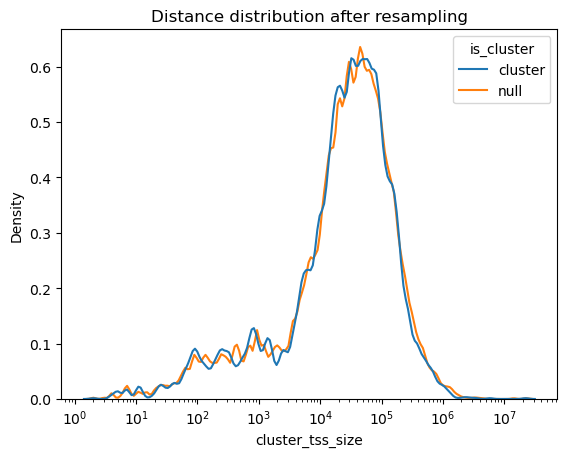

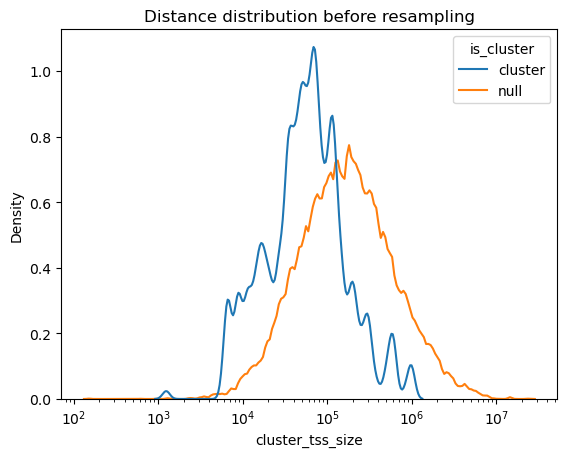

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())


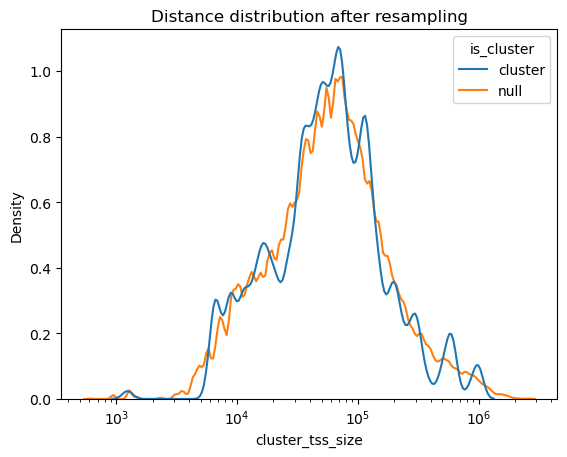

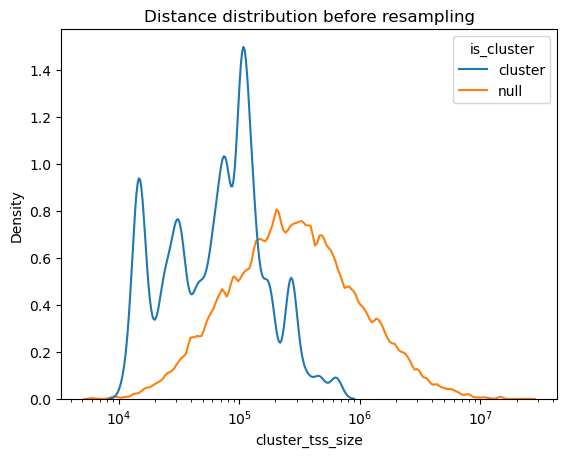

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annota

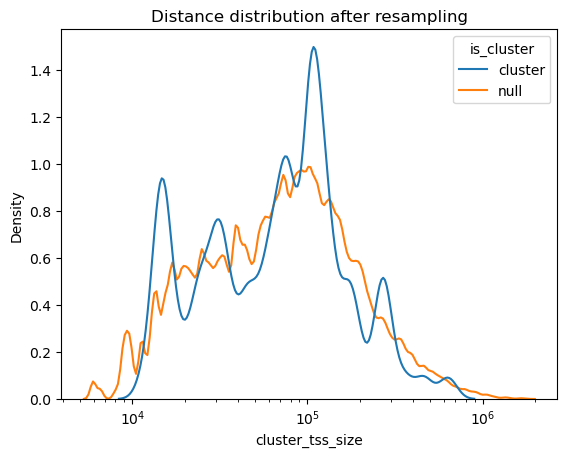

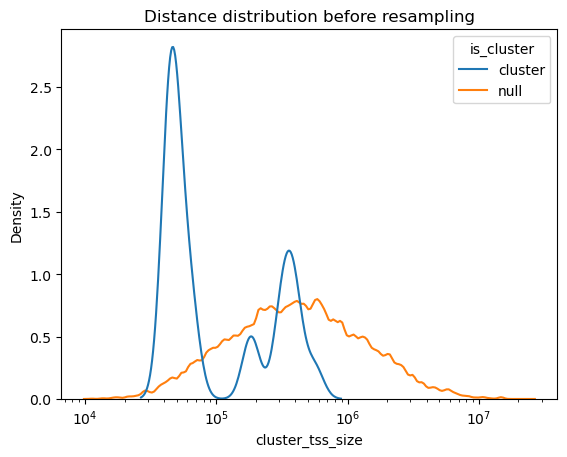

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annota

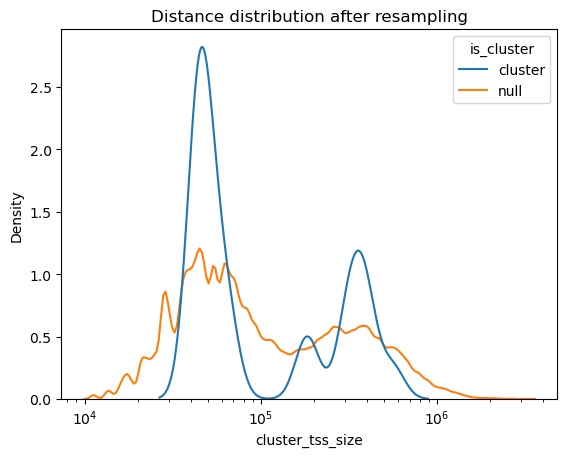

In [45]:
multitissue_abc_resamp_largerclusters_nulls = []
for num_genes in combined_multigene_nulls['N_genes'].unique():
    cluster_num_genes = combined_clusters[(combined_clusters['N_genes']==num_genes) & (combined_clusters['tissue'].isin(enhancer_tissue_ids))]
    # don't bother to match if too few clusters of this size, just discard null
    if len(cluster_num_genes) > 2:
        null_num_genes = combined_multigene_nulls[(combined_multigene_nulls['N_genes']==num_genes) & (combined_multigene_nulls['tissue'].isin(enhancer_tissue_ids))]
        multitissue_abc_resamp_largerclusters_nulls.append(get_resamp_null_cluster(null_num_genes, cluster_num_genes, number_null=5000*len(enhancer_tissue_ids), plot=True))

In [46]:
multitissue_abc_resamp_largerclusters_df = pd.concat([combined_clusters[(combined_clusters['tissue'].isin(enhancer_tissue_ids))], pd.concat(multitissue_abc_resamp_largerclusters_nulls)], keys=['cluster', 'null'], names=['type', 'idx'])
multitissue_abc_resamp_largerclusters_df = multitissue_abc_resamp_largerclusters_df.reset_index()


num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.017801
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                35090
Model:                          Logit   Df Residuals:                    35088
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                0.003475
Time:                        17:46:01   Log-Likelihood:                -624.63
converged:                       True   LL-Null:                       -626.81
Covariance Type:            nonrobust   LLR p-value:                   0.03687
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -5.8172      0.122

<AxesSubplot: >

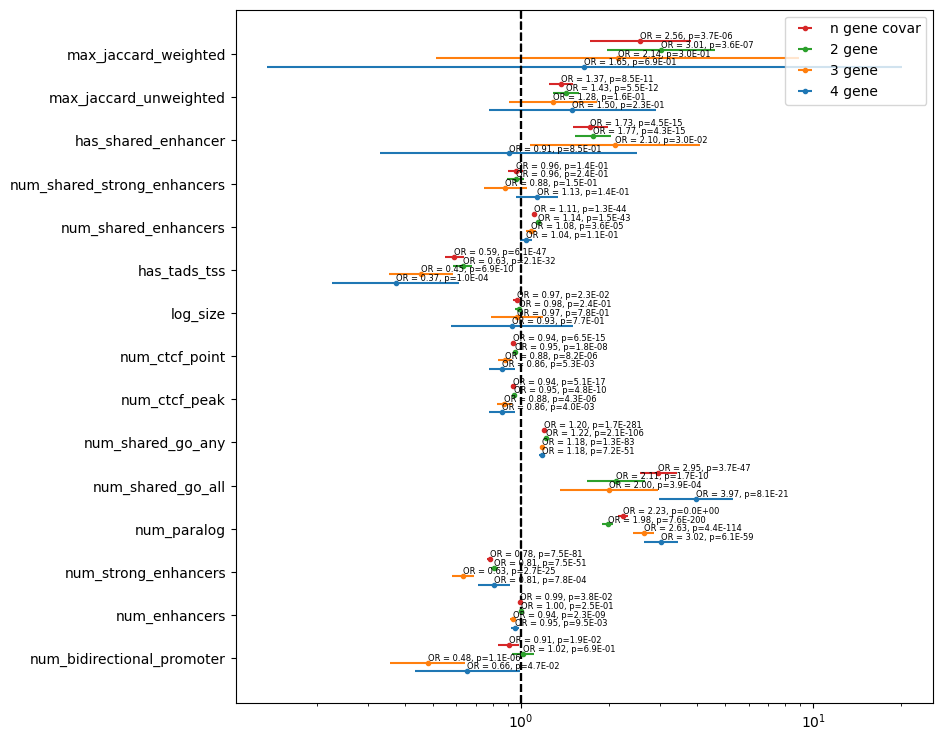

In [47]:
make_log_odds_plot_multiple([*[get_odds_df(multitissue_abc_resamp_largerclusters_df[multitissue_abc_resamp_largerclusters_df['N_genes']==i]) for i in [4,3,2]], 
                             get_odds_df(multitissue_abc_resamp_largerclusters_df, correct_on=True, correct_on_column='N_genes')], 
                             labels=['4 gene', '3 gene', '2 gene', 'n gene covar'])

num_paralog


Optimization terminated successfully.
         Current function value: 0.011728
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               140254
Model:                          Logit   Df Residuals:                   140251
Method:                           MLE   Df Model:                            2
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                  0.1145
Time:                        17:46:34   Log-Likelihood:                -1644.9
converged:                       True   LL-Null:                       -1857.5
Covariance Type:            nonrobust   LLR p-value:                 4.698e-93
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.8187      0.274     -6.646      0.000      -2.355      -1.282
N_genes        -1.7044   

<AxesSubplot: >

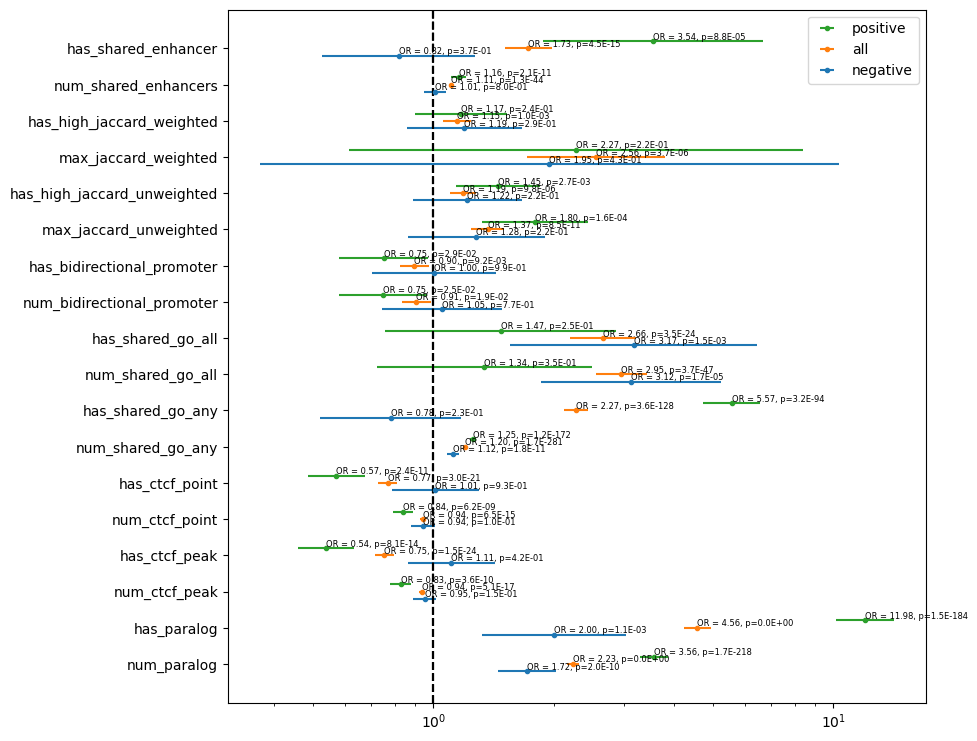

In [48]:
# combined, resamples
make_log_odds_plot_multiple([get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['has_neg_corr'])) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=bool_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes'), 
                             get_odds_df(multitissue_abc_resamp_largerclusters_df, column_list=bool_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes'), 
                             get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['has_high_pos_corr'])) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=bool_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes')], 
                             labels=['negative', 'all', 'positive'])

# cutoffs for boolean labels
I don't understand how 'mean_jaccard_weighted' can have a high coeefcient in a logisitc regression, but then the boolean version 'has_high_jaccard_weighted' doesn't. Maybe this is due to the threshold that determines yes/no for the boolean version?

In [49]:
multitissue_pairs_abc_joined_df['has_multiple_abc_genes'] = multitissue_pairs_abc_joined_df['num_abc_genes'] > 1

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Density'>

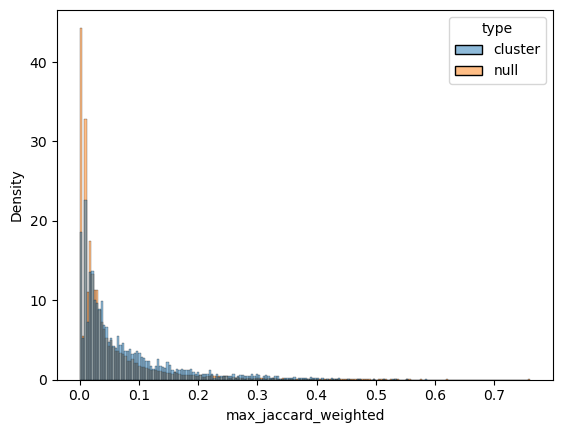

In [50]:
sns.histplot(multitissue_pairs_abc_joined_df[multitissue_pairs_abc_joined_df['has_multiple_abc_genes']], x='max_jaccard_weighted', hue='type', common_norm=False, stat='density')

In [51]:
column = 'max_jaccard_unweighted'
filter_on_column = 'has_multiple_abc_genes'

joined_df = multitissue_pairs_abc_joined_df
try:
    final_joined_df = joined_df[joined_df[filter_on_column]].copy()
except KeyError:
    final_joined_df = joined_df.copy()

num_cutoffs = 20
cutoff_list = [i/num_cutoffs for i in range(num_cutoffs)]

for cutoff in cutoff_list:
    final_joined_df[f'test_{cutoff}'] = final_joined_df[column] > cutoff

cutoff_odds = get_odds_df(final_joined_df, column_list = [f'test_{cutoff}' for cutoff in cutoff_list])
cutoff_odds['cutoff'] = cutoff_list
chosen_cutoff = cutoff_odds.loc[cutoff_odds['odds_ratio'].idxmax()]['cutoff']

test_0.0
Optimization terminated successfully.
         Current function value: 0.379617
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                23694
Model:                          Logit   Df Residuals:                    23692
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                 0.01316
Time:                        17:47:41   Log-Likelihood:                -8994.7
converged:                       True   LL-Null:                       -9114.6
Covariance Type:            nonrobust   LLR p-value:                 4.056e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7759      0.069    -40.489      0.000      -2.910      -2.642
test_0.0       0.983

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Density'>

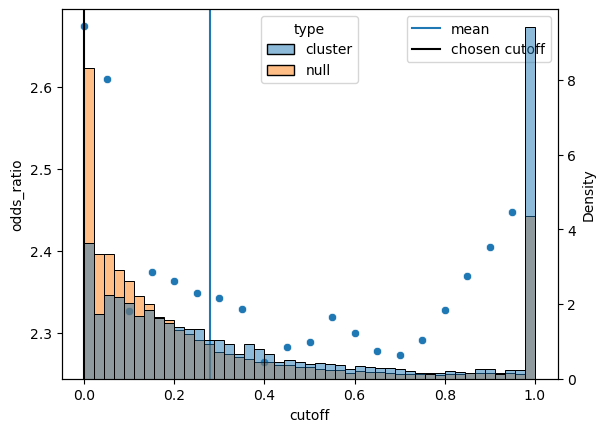

In [52]:
ax = sns.scatterplot(x='cutoff', y='odds_ratio', data=cutoff_odds)
ax.axvline(x=np.mean(final_joined_df[column]), label='mean')
ax.axvline(x=chosen_cutoff, label='chosen cutoff', color='k')
ax.legend()

ax2 = ax.twinx()


sns.histplot(final_joined_df, x=column, hue='type', common_norm=False, stat='density', ax=ax2)

In [53]:
cutoff_odds.loc[cutoff_odds['odds_ratio'].idxmax()]['cutoff']

0.0

#### expression level


In [54]:
# def load_avg_exression(avg_expression_path = f'{prefix}/data/processed/GTEx_Analysis_RSEMv1.gene_tpm.tissue_avg.csv'):
#     tissue_avg_expression = pd.read_csv(avg_expression_path, sep='\t', index_col=0)

# def annotate_avg_expression(cluster_df, tissue_avg_expression):
#     for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
#         transcript_list = row['Transcripts'].split(',')
#         cluster_avg_expression = tissue_avg_expression.loc[row['tissue'],transcript_list]
#         cluster_df.loc[idx, 'avg_expression'] = np.mean(cluster_avg_expression)
#         cluster_df.loc[idx, 'avg_log_expression'] = np.mean(np.log10(cluster_avg_expression))

# annotate_avg_expression(multitissue_abc_resamp_largerclusters_df, load_avg_exression())
# annotate_avg_expression(multitissue_abc_largerclusters_df, load_avg_exression())

In [55]:
# sns.histplot(data=multitissue_abc_largerclusters_df[multitissue_abc_largerclusters_df['type'] == 'cluster'], hue='has_neg_corr', x='avg_log_expression', stat='density', common_norm=False)

In [56]:
# # correct on N_genes and avg log expression
# resamp_column_list = ['has_tads_tss', 
#                       'has_paralog', 
#                       'has_shared_go_any',
#                       'has_ctcf_peak',
#                  #     'max_jaccard_unweighted',
#                       'has_shared_enhancer']
# resamp_odds_positive = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['has_high_pos_corr'])) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column=['N_genes', 'avg_log_expression']) 
# resamp_odds_all = get_odds_df(multitissue_abc_resamp_largerclusters_df, column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column=['N_genes', 'avg_log_expression'])
# resamp_odds_negative = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['has_neg_corr'])) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column=['N_genes', 'avg_log_expression'])

# noresamp_cols = ['log_size', 'has_bidirectional_promoter']
# noresamp_odds_positive = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['has_high_pos_corr'])) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column=['N_genes', 'avg_log_expression'])
# noresamp_odds_all = get_odds_df(multitissue_abc_largerclusters_df, column_list = noresamp_cols, correct_on=True, correct_on_column=['N_genes', 'avg_log_expression'])
# noresamp_odds_negative = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['has_neg_corr'])) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column=['N_genes', 'avg_log_expression'])


In [57]:
# # combined, resamples


# ax = make_log_odds_plot_multiple([pd.concat([resamp_odds_negative,noresamp_odds_negative]),
#                              pd.concat([resamp_odds_all,noresamp_odds_all]), 
#                              pd.concat([resamp_odds_positive,noresamp_odds_positive])], 
#                              labels=['Negative', 'All', 'Positive'], 
#                              colors = sns.color_palette('blend:#B83A4B,k,#67AFD2', n_colors=3))

# ax.set_xlabel('log(Odds Ratio) clusters vs genome wide')
# #ax.set_yticklabels(np.array(['bidirectional promoter', 'tss-tss distance', 'shared enhancer \n    (tss-tss distance corrected)', 'CTCF \n    (tss-tss distance corrected)', 'shared GO term \n    (tss-tss distance corrected)', 'paralog \n    (tss-tss distance corrected)', 'TAD boundry \n    (tss-tss distance corrected)'])[::-1])

### final plot
* N_genes as covar
* resampled distance for all but bidirectional_promoter and log_size
* no jaccard :(

In [58]:
resamp_column_list = ['has_tads_tss', 
                      'has_paralog', 
                      'has_shared_go_any',
                      'has_ctcf_peak',
                 #     'max_jaccard_unweighted',
                      'has_shared_enhancer']

In [59]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1000

In [60]:
# stronger negative cutoff
neg_cutoff = -.001
pos_cutoff = .5

noresamp_cols = ['log_size', 'has_bidirectional_promoter']
noresamp_odds_positive = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['Mean_pos_cor']>pos_cutoff)) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes')
noresamp_odds_all = get_odds_df(multitissue_abc_largerclusters_df, column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes')
noresamp_odds_negative = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['Mean_neg_cor']<neg_cutoff)) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes')

resamp_odds_positive = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['Mean_pos_cor']>pos_cutoff)) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes') 
resamp_odds_all = get_odds_df(multitissue_abc_resamp_largerclusters_df, column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes')
resamp_odds_negative = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['Mean_neg_cor']<neg_cutoff)) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes')


log_size
Optimization terminated successfully.
         Current function value: 0.025401
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               132824
Model:                          Logit   Df Residuals:                   132821
Method:                           MLE   Df Model:                            2
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                  0.1531
Time:                        17:47:47   Log-Likelihood:                -3373.9
converged:                       True   LL-Null:                       -3983.6
Covariance Type:            nonrobust   LLR p-value:                1.510e-265
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1325      0.215      5.277      0.000       0.712       1.553
N_genes       -1.56

In [61]:
# combined, resamples


ax = make_log_odds_plot_multiple([pd.concat([resamp_odds_negative,noresamp_odds_negative]),
                             pd.concat([resamp_odds_all,noresamp_odds_all]), 
                             pd.concat([resamp_odds_positive,noresamp_odds_positive])], 
                             labels=['Negative', 'All', 'Positive'], 
                             colors = sns.color_palette('blend:#B83A4B,k,#67AFD2', n_colors=3))

ax.set_xlabel('log(Odds Ratio) clusters vs genome wide')
ax.set_yticklabels(np.array(['bidirectional promoter', 'tss-tss distance', 'shared enhancer \n    (tss-tss distance corrected)', 'CTCF \n    (tss-tss distance corrected)', 'shared GO term \n    (tss-tss distance corrected)', 'paralog \n    (tss-tss distance corrected)', 'TAD boundry \n    (tss-tss distance corrected)'])[::-1])
#ax.set_xlim([.1, 100])

[Text(0, 0.2, 'TAD boundry \n    (tss-tss distance corrected)'),
 Text(0, 1.2, 'paralog \n    (tss-tss distance corrected)'),
 Text(0, 2.2, 'shared GO term \n    (tss-tss distance corrected)'),
 Text(0, 3.2, 'CTCF \n    (tss-tss distance corrected)'),
 Text(0, 4.2, 'shared enhancer \n    (tss-tss distance corrected)'),
 Text(0, 5.2, 'tss-tss distance'),
 Text(0, 6.2, 'bidirectional promoter')]

In [62]:
print("test")

test


/local/scratch/klawren/slrmtmp.46562935/ipykernel_39064/320153873.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.array(['bidirectional promoter', 'TSS-TSS distance', 'shared ABC enhancer', 'CTCF peak between TSSs', 'shared GO term', 'paralogs', 'crosses TAD boundry'])[::-1], fontsize=12)


[Text(0, 0, 'crosses TAD boundry'),
 Text(0, 1, 'paralogs'),
 Text(0, 2, 'shared GO term'),
 Text(0, 3, 'CTCF peak between TSSs'),
 Text(0, 4, 'shared ABC enhancer'),
 Text(0, 5, 'TSS-TSS distance'),
 Text(0, 6, 'bidirectional promoter')]

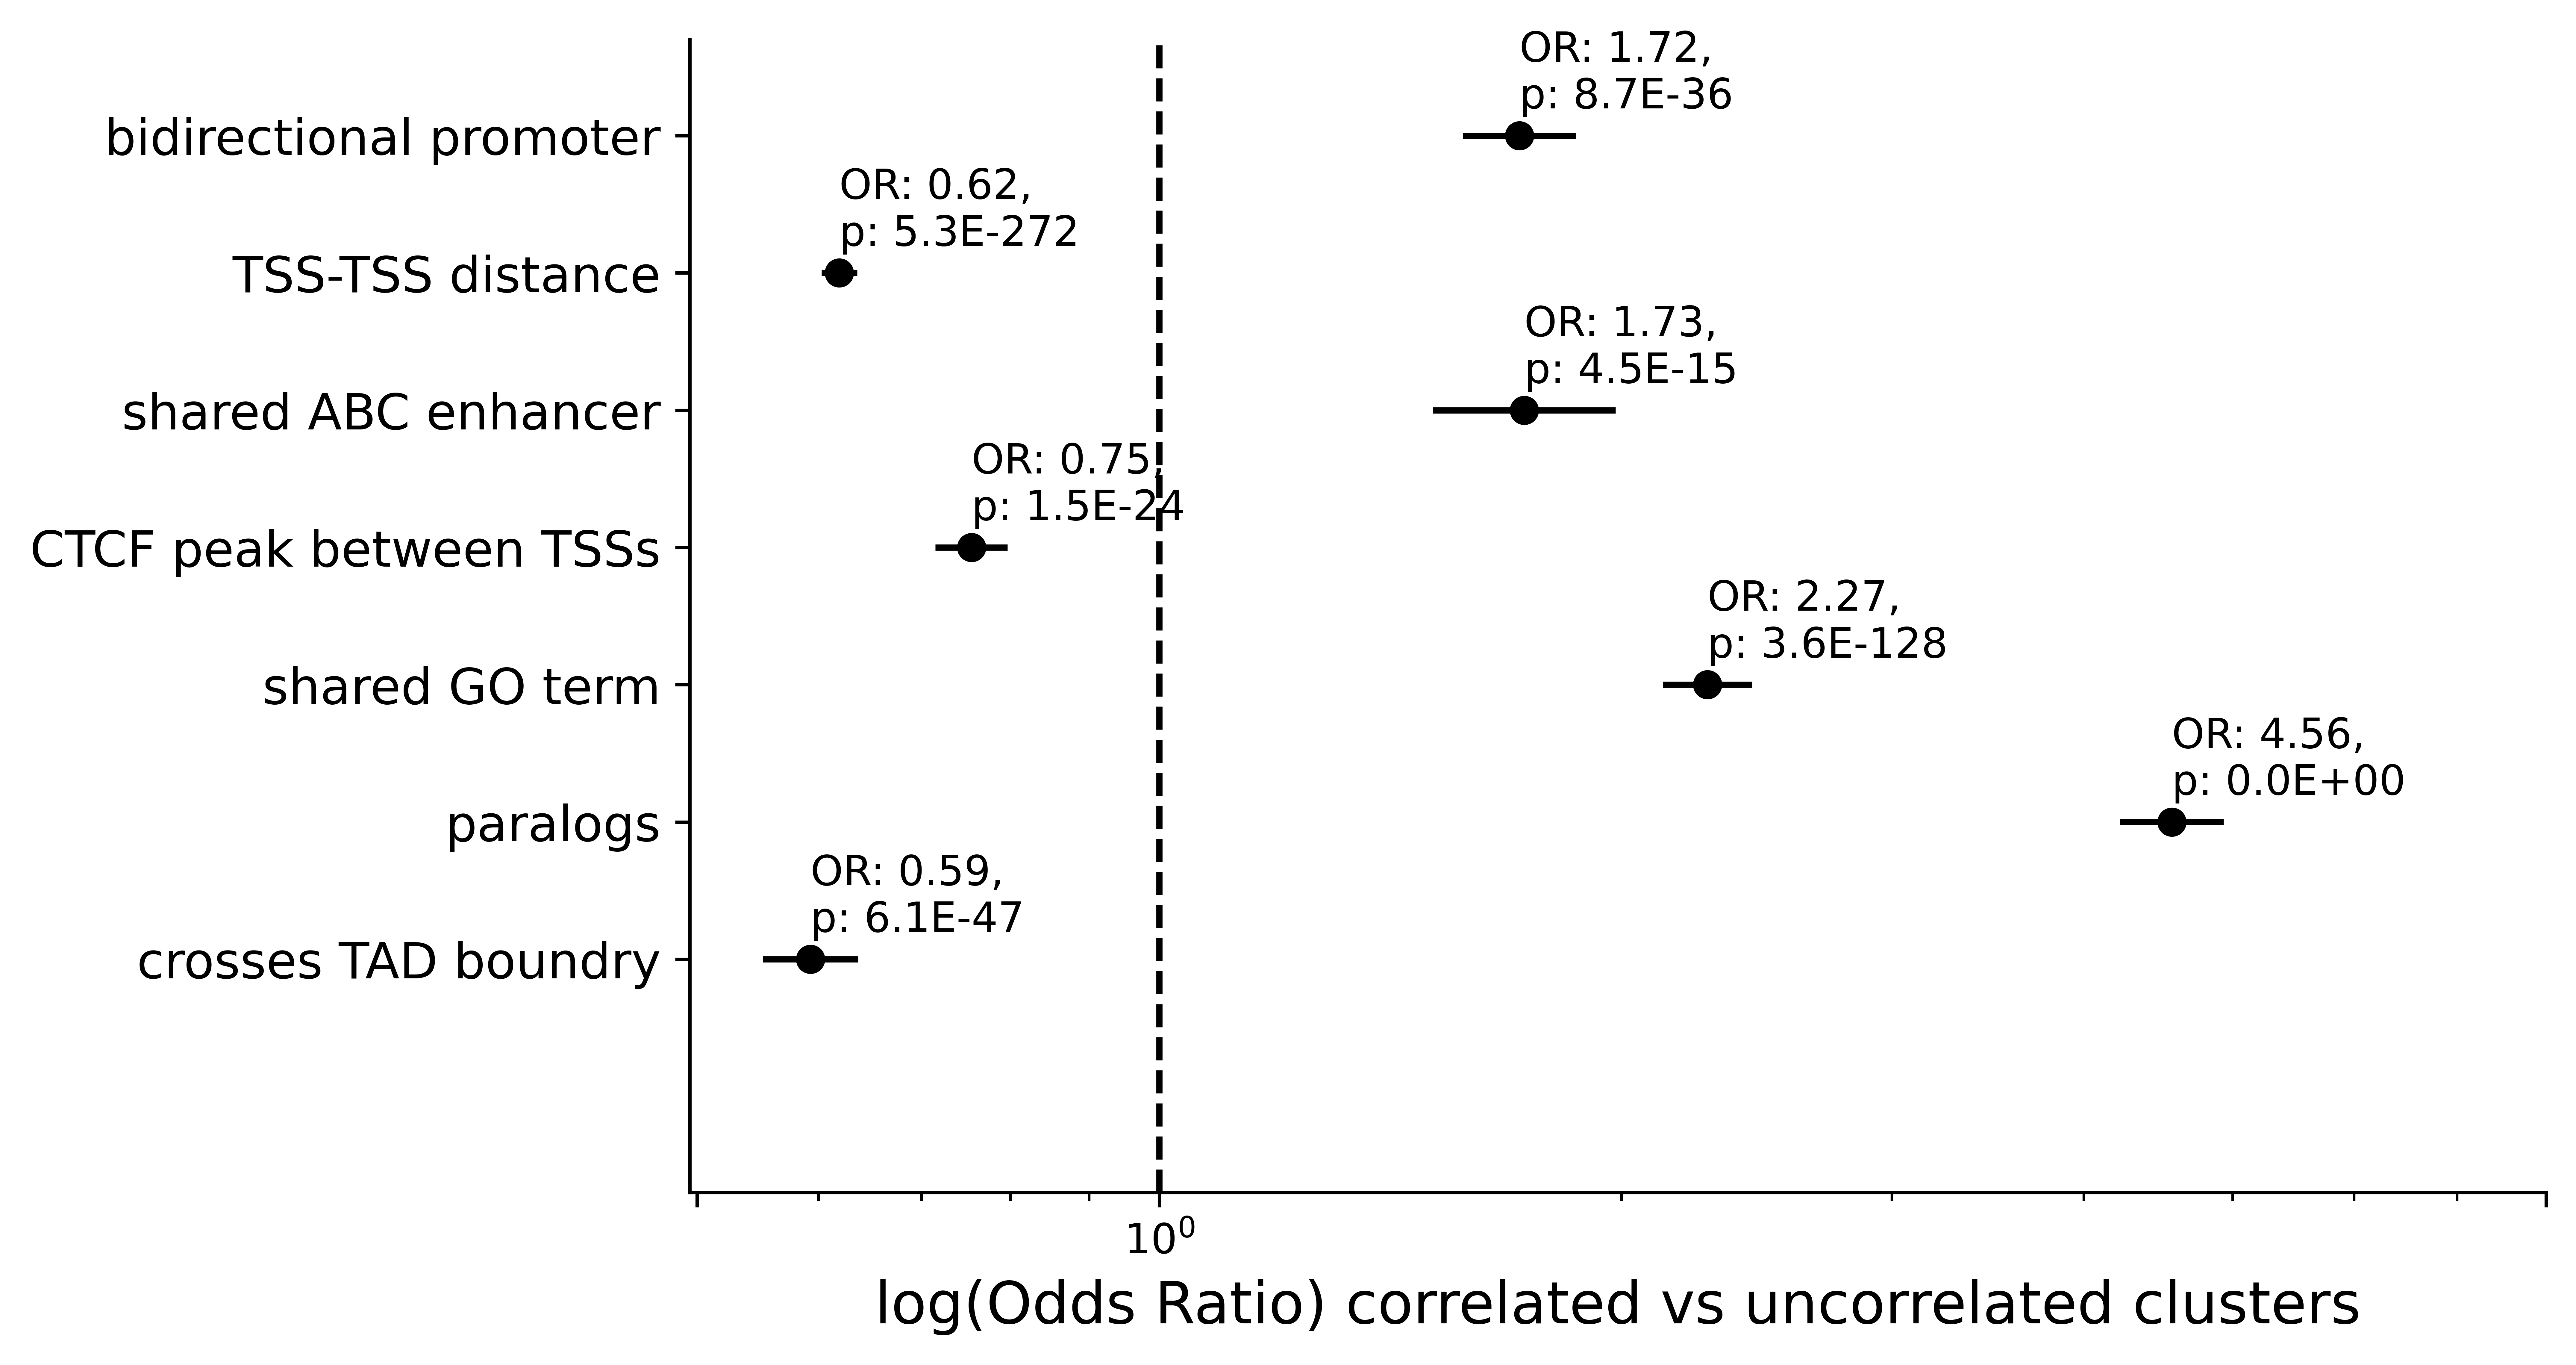

In [63]:
# without pos and negaitve split out
fig, ax = plt.subplots(figsize=(8,5))
ax = make_log_odds_plot(pd.concat([resamp_odds_all,noresamp_odds_all]), ax=ax)

ax.set_xticks([.5, 1, 8], fontsize=12)
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-1.4, ylim[1]+.4)
ax.set_xlabel('log(Odds Ratio) correlated vs uncorrelated clusters', fontsize=14)
ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)


ax.set_yticklabels(np.array(['bidirectional promoter', 'TSS-TSS distance', 'shared ABC enhancer', 'CTCF peak between TSSs', 'shared GO term', 'paralogs', 'crosses TAD boundry'])[::-1], fontsize=12)

In [64]:
# stronger negative cutoff
pos1_cutoff = .3
pos2_cutoff = .7

noresamp_cols = ['log_size', 'has_bidirectional_promoter']
noresamp_odds_pos1 = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['Mean_pos_cor']>pos1_cutoff)) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes')
noresamp_odds_all = get_odds_df(multitissue_abc_largerclusters_df, column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes')
noresamp_odds_pos2 = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['Mean_pos_cor']>pos2_cutoff)) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes')

resamp_odds_pos1 = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['Mean_pos_cor']>pos1_cutoff)) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes') 
resamp_odds_all = get_odds_df(multitissue_abc_resamp_largerclusters_df, column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes')
resamp_odds_pos2 = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['Mean_pos_cor']>pos2_cutoff)) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes')


log_size
Optimization terminated successfully.
         Current function value: 0.088482
         Iterations 10


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               135285
Model:                          Logit   Df Residuals:                   135282
Method:                           MLE   Df Model:                            2
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                  0.1871
Time:                        17:48:21   Log-Likelihood:                -11970.
converged:                       True   LL-Null:                       -14725.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5045      0.097     25.801      0.000       2.314       2.695
N_genes       -1.4276      0.037    -38.321      0.000      -1.501      -1.355
log_size      -0.5039      0.018    -28.592      0.0

In [65]:
# combined, resamples


ax = make_log_odds_plot_multiple([pd.concat([resamp_odds_all,noresamp_odds_all]), 
                             pd.concat([resamp_odds_pos1,noresamp_odds_pos1]),
                             pd.concat([resamp_odds_pos2,noresamp_odds_pos2])], 
                             labels=['> .2', '> .3', '> .7'], 
                             colors = sns.color_palette('blend:#B83A4B,k,#67AFD2', n_colors=3))

ax.set_xlabel('log(Odds Ratio) clusters vs genome wide')
ax.set_yticklabels(np.array(['bidirectional promoter', 'tss-tss distance', 'shared enhancer \n    (tss-tss distance corrected)', 'CTCF \n    (tss-tss distance corrected)', 'shared GO term \n    (tss-tss distance corrected)', 'paralog \n    (tss-tss distance corrected)', 'TAD boundry \n    (tss-tss distance corrected)'])[::-1])

[Text(0, 0.2, 'TAD boundry \n    (tss-tss distance corrected)'),
 Text(0, 1.2, 'paralog \n    (tss-tss distance corrected)'),
 Text(0, 2.2, 'shared GO term \n    (tss-tss distance corrected)'),
 Text(0, 3.2, 'CTCF \n    (tss-tss distance corrected)'),
 Text(0, 4.2, 'shared enhancer \n    (tss-tss distance corrected)'),
 Text(0, 5.2, 'tss-tss distance'),
 Text(0, 6.2, 'bidirectional promoter')]